### Echo State Networks application: Classification and layer-wise relevance propagation on ENSO

Inspired by [Woodward et al., 2011](https://www.sacral.c.u-tokyo.ac.jp/pdf/woodward_ivcnz_2011.pdf) paper "A Reservoir Computing approach to Image Classification using Coupled Echo State and Back-Propagation Neural Networks", [Schaetti et al., 2016](https://ieeexplore.ieee.org/document/7982291) paper "Echo State Networks-Based Reservoir Computing for MNIST Handwritten Digits Recognition" and [Toms et al, 2020](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019MS002002) paper "Physically Interpretable Neural Networks for the Geosciences: Applications to Earth System Variability", we want to reproduce some of their results and go beyond. 

#### Data and derived sst anomaly index

SST data: https://downloads.psl.noaa.gov/Datasets/noaa.ersst.v5/sst.mnmean.nc

Data contains **monthly mean SST** from 1854 .. 2021, in a 2° by 2° lat/lon grid:  
**lat:** 88N .. -88N (= 88S)  
**lon:** 0E .. 358E

Start from 1880. Following https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni and using the NINO3.4 box, we can diagnose the El-Nino-Southern-Oscillation Index (ENSO) from sea-surface temperature (SST). However, recipe for calculating ENSO requires some rolling mean. We omit the rolling mean here and directly take **sst anomaly index** instead.

#### Outline

- Calculate sst anomaly index
- Pre-processing of model inputs and targets
- Classify sst anomaly fields (El Nino / La Nina)
- Layer-wise relevance propagation
- Compare results for different models:
 * Linear regression
 * Multilayer perceptron
 * Echo State Network: Feed inputs column-wise

### Tech preamble

In [1]:
import numpy as np
import xarray as xr
import hvplot.xarray
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from scipy.special import softmax, expit

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, concatenate, Conv1D, LSTM, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow.keras.initializers as tfi
import tensorflow.keras.regularizers as tfr
from tensorflow.keras.utils import plot_model

### Import library of useful ESN functions
import sys
sys.path.append('../src/models')
from ESN_functions import ESN, setESN, trainESN, predESN

### Load SST data

In [2]:
## Download raw data from Zenodo (90 MByte): Only once!
#! curl https://zenodo.org/record/6517186/files/sst.mnmean.nc -o ../data/raw/sst.mnmean.nc

In [3]:
# Set relative path on local machine (or remote machine)
sst_path = "../data/raw/sst.mnmean.nc"

# Load data
sst_dataset = xr.open_dataset(sst_path)

# Get summary statistics and source information
sst_dataset

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, time: 2019, nbnds: 2)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2022-03-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 ...
    sst        (time, lat, lon) float32 ...
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2022-05-03

### Calculating SST anomaly index from sst data

There are several indices used to monitor the tropical Pacific, all of which are based on SST anomalies averaged across a given region.  Usually the anomalies are computed relative to a base period of 30 years.  The Niño 3.4 index is one of the most commonly used indices to define El Niño and La Niña events.

Website https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni gives introduction to ENSO indices. [Morrow et al., 2010](http://www.ccpo.odu.edu/~klinck/Reprints/PDF/morrowJGR2010.pdf) show in their paper "Eddy response to Southern Ocean climate modes" an index for Niño 3.4 region (5°N–5°S, 120–170°W) in the tropical Pacific. The website references a link to an "expert guide" with more detailed information and a recipe on calculating ENSO indices:

(...) Nino X Index computation: (a) Compute area averaged total SST from Niño X region; (b) Compute monthly climatology (here 1980-2009) for area averaged total SST from Niño X region, and subtract climatology from area averaged total SST time series to obtain anomalies; (c) Smooth the anomalies with a 5-month running mean; (d) Normalize the smoothed values by its standard deviation over the climatological period. (...)

**Note:** We omit smoothing with rolling mean here and hence call it *sst anomaly index* instead of *ENSO index*.

In [4]:
### Compute area averaged total SST from Niño 3.4 region (5°N–5°S, 120–170°W).
# Note: Since the box of interest is close to equator (5°N-5°S) we simply average over the box area and don't take
# care of area weighting here.
# Note: latitude comes in a grid 88, 86, .., -86, 88, slice(5,-5) is actually using (4°N-4°S) only.
# Note: longitude ranges from 0 to 358°E. Region of interest (120-170°W) translates to (190°E-240°E) here.
sst_mean = (
    sst_dataset.sst.sel(time=slice('1880-01-01', '2021-11-01'))
    .sel(lat=slice(5,-5)).sel(lon=slice(190,240))
    .mean(("lat", "lon"))
)

# Compute monthly climatology (here: 1980-2009) for area averaged total SST from Niño 3.4 region.
# "Monthly" means grouping by month before calculating average over time.
sst_climatology_monthly = (
    sst_dataset.sst
    .sel(time=slice('1980-01-01','2009-12-01'))
    .sel(lat=slice(5,-5))
    .sel(lon=slice(190,240))
    .mean(("lat", "lon"))
    .groupby("time.month")
    .mean("time")    
)

# Compute std dev in time for total climatology (here: 1980-2009), 
# use area averaged total SST from Niño 3.4 region
sst_climatology_total_std = (
    sst_dataset.sst
    .sel(time=slice('1980-01-01','2009-12-01'))
    .sel(lat=slice(5,-5))
    .sel(lon=slice(190,240))
    .mean(("lat", "lon"))
    .std("time")          
)

# Subtract monthly climatology from area averaged total SST time series to obtain anomalies
sst_anomaly_monthly = sst_mean.groupby("time.month") - sst_climatology_monthly

# ENSO index is calculated as 5 months rolling mean of sst anomaly.
# We aim to label time sclices of lat/lon grids according to their phase: "El Nino" / "La Nina".
# This requires sst_anomaly WITHOUT rolling mean!
# But still normalize sst anomaly by dividing by standard deviation of sst climatology, as required for ENSO index:
sst_anomaly_norm = sst_anomaly_monthly / sst_climatology_total_std

### Pre-processing of model inputs and targets

Different models require different inputs and targets. Linear regression and multilayer perceptron perform best on **capped** ([-5°C, 5°C]), **scaled** ([-1,1]) and **flattened** sst anomaly fields as inputs (only valid gridpoints!). 

Our base ESN Model we take **capped** ([-5°C, 5°C]) and **scaled** ([-1,1]) 2D sst anomaly fields as inputs. Opposed to linear regression and multilayer perceptron, we keep *ALL* gridpoints. And passing inputs column-wise requires **swapping** of latitude and longitude, to have longitude as time dimension.

In any case we have un-scaled **continuous** normalized sst anomaly index as targets.

**Note:** While preprocessing input data, we (optionally) add a **dummy column** of *ONEs* as first column to swapped inputs. This is required, since we want the dummy column to capture residual relevance in later experiments.

rel. amount of NaN values in inputs:  0.314
NaN values in inputs BEFORE setting NaN to ZERO:  5238312
ZERO values in inputs BEFORE setting NaN to ZERO:  4
ZERO values in inputs AFTER setting NaN to ZERO:  5238316
rel. amount of valid gridpoints:  0.686


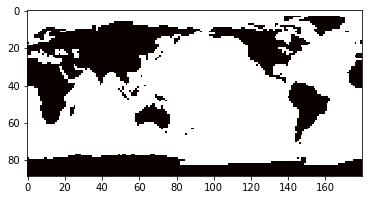


inputs shape (all input samples):  (1041, 89, 180)
train_input shape:  (832, 89, 180)
train_input_swap shape:  (832, 181, 89)
val_input shape:  (209, 89, 180)
val_input_swap shape:  (209, 181, 89)

NaN values removed:  True
train_input_flat shape:  (832, 1, 10988)
train_input_flat_small shape:  (832, 1, 2772)
val_input_flat shape:  (209, 1, 10988)
val_input_flat_small shape:  (209, 1, 2772)

targets shape (all targets):  (1041, 1)
train_target shape:  (832, 1)
train_target_bin shape:  (832, 1)
train_target_onehot shape:  (832, 2)
val_target shape:  (209, 1)
val_target_bin shape:  (209, 1)
val_target_onehot shape:  (209, 2)

cap method:  abs_lim
train_inputs min:  -5.0
train_inputs max:  5.0

scaled train_inputs min:  -1.0
scaled train_inputs max:  1.0
scaled val_inputs min:  -1.0
scaled val_inputs max:  1.0

un-scaled train_target min:  -2.8181634
un-scaled train_target max:  2.4123752
un-scaled val_target min:  -1.7919745
un-scaled val_target max:  2.7973337

scaled train_target min:

In [5]:
### Prepare inputs and targets from sst anomaly fields

## Set parameters upfront:

train_val_split = 0.8 # Set rel. amount of samples used for training.
scale_to = 'one_one' # Choose to scale inputs to [-1,1] ('one_one') or [0,1] ('zero_one'), or 'no' scaling.
remove_NaN = True # If True, gridoints of former NaN values (set to zero) are NOT included in vectorized inputs.
add_dummy_col = True # If True, add dummy column of ONEs as first column to swapped input samples.

# Either set limits to quantile limits (e.g. 0.005 and 0.995% quantile) or set absolute limits:
cap_method = 'abs_lim' # 'q_lim' or 'abs_lim'

# For working with absolute limits, specify upper and lower limit:
upper_cap_limit = 5
lower_cap_limit = -5

# For working with quantile limits, specify percentile:
quantile_perc = 0.005

# Again start with raw sst fields as lat/lon grids in time, from 1880 to date:
sst_fields = (
    sst_dataset.sst
    .sel(time=slice('1880-01-01', '2021-11-01'))
)

# Compute monthly climatology (here 1980 - 2009) for whole world
sst_climatology_fields = (
    sst_dataset.sst
    .sel(time=slice('1980-01-01','2009-12-01'))
    .groupby("time.month")
    .mean("time")
)

# Get sst anomaly fields by subtracting monthly climatology from raw sst fields:
sst_anomaly_fields = sst_fields.groupby("time.month") - sst_climatology_fields

# Only keep sst anomaly fields connected either El Nino or La Nina event.
sst_anomaly_fields_NinoNina = sst_anomaly_fields[(sst_anomaly_norm.values > 0.5) | (sst_anomaly_norm.values < -0.5)]

# Extract sst anomaly fields' values as iputs:
inputs = np.copy(sst_anomaly_fields_NinoNina.values)

# Check how many NaN values we have, coming from landmasses, where we obviously don't have sst values:
temp_isnan = np.isnan(sst_anomaly_fields_NinoNina.values)
temp_isnan_rel = np.sum(temp_isnan) / np.size(temp_isnan)
print("rel. amount of NaN values in inputs: ", np.round(temp_isnan_rel,3))
print("NaN values in inputs BEFORE setting NaN to ZERO: ", np.sum(temp_isnan))

# Check for existing ZERO values in inputs BEFORE setting NaN to ZERO
print("ZERO values in inputs BEFORE setting NaN to ZERO: ", np.sum(inputs==0))

## Set NaN values to ZERO.
# It might be a problem to first set nan values to zero, then apply min/max scaling.
# After scaling former NaN values are non-zero!
# On the other hand we cannot get necessary min/max values as long as we have NaN values.
# Solution: Replace NaN by zero. Apply min/max scaling. Then again set former NaN values to zero.
inputs[temp_isnan] = 0
print("ZERO values in inputs AFTER setting NaN to ZERO: ", np.sum(inputs==0))

# Get targets from sst anomaly index:
targets = sst_anomaly_norm.values[(sst_anomaly_norm.values > 0.5) | (sst_anomaly_norm.values < -0.5)]

# Convert targets to binary targets (1 / 0) for El Nino / La Nina.
targets_bin = (targets > 0.5).astype(int)

# Reshape targets to (samples, 1):
targets = targets.reshape((len(targets), 1))
targets_bin = targets_bin.reshape((len(targets_bin), 1))

# Create one-hot targets for two unit output (El Nino / La Nina):
targets_onehot = np.concatenate([(targets_bin==1).astype(int),(targets_bin==0).astype(int)], axis=1)

## Take care of outliers in sst anomaly values:

# Get number of train samples:
n_train = int(len(inputs) * train_val_split)

# Copy inputs to provide un-capped version:
inputs_uncapped = np.copy(inputs)

# Act according to desired cap-method - either use quantile limits or specified absolute limits:
if cap_method == 'abs_lim':

    # Set inputs with values outside specified limits to limit value:
    inputs[inputs > upper_cap_limit] = upper_cap_limit
    inputs[inputs < lower_cap_limit] = lower_cap_limit

elif cap_method == 'q_lim':   
    
    # get quantile limits for specified X% quantile on TRAIN data
    q_lower_limit = np.quantile(inputs[:n_train].flatten(), quantile_perc)
    q_upper_limit = np.quantile(inputs[:n_train].flatten(), 1 - quantile_perc)
    
    # OR: get quantile limits for specified X% quantile on ALL data
    #q_lower_limit = np.quantile(inputs.flatten(), quantile_perc)
    #q_upper_limit = np.quantile(inputs.flatten(), 1 - quantile_perc)
    
     # Set inputs with values outside specified limits to limit value:
    inputs[inputs > q_upper_limit] = q_upper_limit
    inputs[inputs < q_lower_limit] = q_lower_limit
    
## Split inputs and targets into train and validation data according to train_val_split.

## Optionally scale capped and uncapped inputs to [-1,1] or [0,1] 
## according to min/max obtained from only train inputs.

# Remenber min/max used for scaling.
train_min = np.min(inputs[:n_train])
train_max = np.max(inputs[:n_train])
train_min_uncapped = np.min(inputs_uncapped[:n_train])
train_max_uncapped = np.max(inputs_uncapped[:n_train])

# Scale inputs depending on desired scaling parameter:
if scale_to == 'one_one':
    # Scale inputs to [-1,1]:
    inputs = 2 * (inputs - train_min) / (train_max - train_min) - 1
    inputs_uncapped = 2 * (inputs_uncapped - train_min_uncapped) / (train_max_uncapped - train_min_uncapped) - 1
    
elif scale_to == 'zero_one':
    # Alternatively scale inputs to [0,1]
    inputs = (inputs - train_min) / (train_max - train_min)
    inputs_uncapped = (inputs_uncapped - train_min_uncapped) / (train_max_uncapped - train_min_uncapped)

# Again set former nan values to zero after scaling:
inputs[temp_isnan] = 0
inputs_uncapped[temp_isnan] = 0
    
## Create inputs with swapped lat <-> lon for feeding inputs column-wise into base ESN:
inputs_swap = np.swapaxes(inputs,1,2)
inputs_swap_uncapped = np.swapaxes(inputs_uncapped,1,2)

## Get valid gridpoints:
valid_gridpoints = (temp_isnan == False)
print("rel. amount of valid gridpoints: ",np.round(np.sum(valid_gridpoints) / np.size(valid_gridpoints),3))

# Plot valid gridpoints
plt.imshow(valid_gridpoints[0], cmap='hot', interpolation='nearest')
plt.show()

## Create additional inputs with reduced resolution:
## Reduce inputs' dimension by a factor of 2 for both, lat and lon: Only take every second gridpoint into account.
inputs_small = inputs[:,np.arange(0,inputs.shape[1],2),:]
inputs_small = inputs_small[:,:,np.arange(0,inputs.shape[2],2)]
inputs_uncapped_small = inputs_uncapped[:,np.arange(0,inputs_uncapped.shape[1],2),:]
inputs_uncapped_small = inputs_uncapped_small[:,:,np.arange(0,inputs_uncapped.shape[2],2)]

# Now need valid gridpoints in reduced size by factor af 2 for both, lat and lon:
valid_gridpoints_small = valid_gridpoints[:,np.arange(0,valid_gridpoints.shape[1],2),:]
valid_gridpoints_small = valid_gridpoints_small[:,:,np.arange(0,valid_gridpoints.shape[2],2)]

## Create flattened inputs, optionally remove invalid gridoints:

# Now only keep valid inputs and flatten inputs, then restore first dimension as "samples" 
# and second dimension as "time step" by reshaping:
if remove_NaN==True:
    inputs_flat = np.reshape(inputs[valid_gridpoints], (inputs.shape[0], 1, np.sum(valid_gridpoints[0].astype(int))))
    inputs_uncapped_flat = np.reshape(inputs_uncapped[valid_gridpoints], (inputs_uncapped.shape[0], 1, np.sum(valid_gridpoints[0].astype(int))))
    inputs_flat_small = np.reshape(inputs_small[valid_gridpoints_small], (inputs_small.shape[0], 1, np.sum(valid_gridpoints_small[0].astype(int))))
    inputs_uncapped_flat_small = np.reshape(inputs_uncapped_small[valid_gridpoints_small], (inputs_uncapped_small.shape[0], 1, np.sum(valid_gridpoints_small[0].astype(int))))

# Alternatively keep all inputs, but still flatten inputs, then restore first dimension as "samples" 
# and second dimension as "time step" by reshaping:
elif remove_NaN==False:
    inputs_flat = np.reshape(inputs, (inputs.shape[0], 1, inputs.shape[1] * inputs.shape[2]))
    inputs_uncapped_flat = np.reshape(inputs_uncapped, (inputs.shape[0], 1, inputs.shape[1] * inputs.shape[2]))
    inputs_flat_small = np.reshape(inputs_small, (inputs_small.shape[0], 1, inputs_small.shape[1] * inputs_small.shape[2]))
    inputs_uncapped_flat_small = np.reshape(inputs_uncapped_small, (inputs_small.shape[0], 1, inputs_small.shape[1] * inputs_small.shape[2]))

# Optionally add dummy column to swapped inputs containing only ONEs:
if add_dummy_col==True:
    inputs_swap = np.concatenate([np.ones((1041,1,89)), inputs_swap], axis=1)    
    
## Split inputs and targets:
train_input = inputs[:n_train]
train_input_uncapped = inputs_uncapped[:n_train]
train_input_flat = inputs_flat[:n_train]
train_input_uncapped_flat = inputs_uncapped_flat[:n_train]
train_input_flat_small = inputs_flat_small[:n_train]
train_input_uncapped_flat_small = inputs_uncapped_flat_small[:n_train]
train_input_swap = inputs_swap[:n_train]
train_input_swap_uncapped = inputs_swap_uncapped[:n_train]
val_input = inputs[n_train:]
val_input_uncapped = inputs_uncapped[n_train:]
val_input_flat = inputs_flat[n_train:]
val_input_uncapped_flat = inputs_uncapped_flat[n_train:]
val_input_flat_small = inputs_flat_small[n_train:]
val_input_uncapped_flat_small = inputs_uncapped_flat_small[n_train:]
val_input_swap = inputs_swap[n_train:]
val_input_swap_uncapped = inputs_swap_uncapped[n_train:]
train_target = targets[:n_train]
train_target_bin = targets_bin[:n_train]
train_target_onehot = targets_onehot[:n_train]
val_target = targets[n_train:]
val_target_bin = targets_bin[n_train:]
val_target_onehot = targets_onehot[n_train:]

## Additionally scale targets to [-1,1] according to min/max obtained from only train targets.
# Remenber min/max used for scaling.
train_target_min = np.min(train_target)
train_target_max = np.max(train_target)
# Scale
train_target_scaled = 2 * (train_target - train_target_min) / (train_target_max - train_target_min) - 1
val_target_scaled = 2 * (val_target - train_target_min) / (train_target_max - train_target_min) - 1

# Dimensionality check:
print("\ninputs shape (all input samples): ", inputs.shape)
print("train_input shape: ", train_input.shape)
print("train_input_swap shape: ", train_input_swap.shape)
print("val_input shape: ", val_input.shape)
print("val_input_swap shape: ", val_input_swap.shape)
print("\nNaN values removed: ", remove_NaN)
print("train_input_flat shape: ", train_input_flat.shape)
print("train_input_flat_small shape: ", train_input_flat_small.shape)
print("val_input_flat shape: ", val_input_flat.shape)
print("val_input_flat_small shape: ", val_input_flat_small.shape)
print("\ntargets shape (all targets): ", targets.shape)
print("train_target shape: ", train_target.shape)
print("train_target_bin shape: ", train_target_bin.shape)
print("train_target_onehot shape: ", train_target_onehot.shape)
print("val_target shape: ", val_target.shape)
print("val_target_bin shape: ", val_target_bin.shape)
print("val_target_onehot shape: ", val_target_onehot.shape)
print("\ncap method: ", cap_method)
print("train_inputs min: ", train_min)
print("train_inputs max: ", train_max)
print("\nscaled train_inputs min: ", np.min(train_input))
print("scaled train_inputs max: ", np.max(train_input))
print("scaled val_inputs min: ", np.min(val_input))
print("scaled val_inputs max: ", np.max(val_input))
print("\nun-scaled train_target min: ", np.min(train_target))
print("un-scaled train_target max: ", np.max(train_target))
print("un-scaled val_target min: ", np.min(val_target))
print("un-scaled val_target max: ", np.max(val_target))
print("\nscaled train_target min: ", np.min(train_target_scaled))
print("scaled train_target max: ", np.max(train_target_scaled))
print("scaled val_target min: ", np.min(val_target_scaled))
print("scaled val_target max: ", np.max(val_target_scaled))



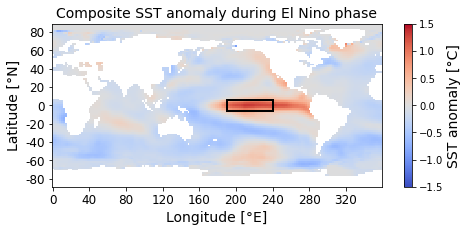

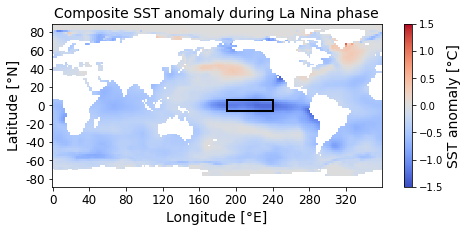

In [13]:
## Split sst anomaly fields related to El Nino or La Nina, respectively:

# El Nino
sst_anomaly_fields_ElNino = sst_anomaly_fields[(sst_anomaly_norm.values > 0.5)]

# La Nina
sst_anomaly_fields_LaNina = sst_anomaly_fields[(sst_anomaly_norm.values < -0.5)]

## Get mean sst anomaly field as composit of all sst fields belonging to either "El Nino" or "La Nina":

# El Nino
sst_anomaly_mean_ElNino = (
    sst_anomaly_fields_ElNino
    .mean("time")
)

# La Nina
sst_anomaly_mean_LaNina = (
    sst_anomaly_fields_LaNina
    .mean("time")
)

## Plot sst anomaly fields for the world, with bounding box arround Nino3.4 area

# El Nino
fig, ax = plt.subplots(figsize=(8, 3))

im = plt.imshow(sst_anomaly_mean_ElNino.values, cmap="coolwarm", interpolation='nearest', vmin=-1.5, vmax=1.5)
cbar = plt.colorbar(im)
cbar.set_label("SST anomaly [°C]", fontsize=14)

plt.title('Composite SST anomaly during El Nino phase', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 180, step=20), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([4, 14, 24, 34, 44, 54, 64, 74, 84], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

# Create a Rectangle patch and add the patch to the Axes
rect = patches.Rectangle((95, 41), 25, 6, linewidth=2, edgecolor='black', facecolor='none')
ax.add_patch(rect)

plt.show()


# La Nina
fig, ax = plt.subplots(figsize=(8, 3))

im = plt.imshow(sst_anomaly_mean_LaNina.values, cmap="coolwarm", interpolation='nearest', vmin=-1.5, vmax=1.5)
cbar = plt.colorbar(im)
cbar.set_label("SST anomaly [°C]", fontsize=14)

plt.title('Composite SST anomaly during La Nina phase', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 180, step=20), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([4, 14, 24, 34, 44, 54, 64, 74, 84], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

# Create a Rectangle patch and add the patch to the Axes
rect = patches.Rectangle((95, 41), 25, 6, linewidth=2, edgecolor='black', facecolor='none')
ax.add_patch(rect)

plt.show()


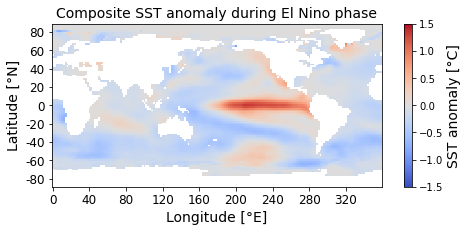

In [14]:
## Plot sst anomaly fields for the world, without bounding box arround Nino3.4 area

# El Nino
fig, ax = plt.subplots(figsize=(8, 3))

im = plt.imshow(sst_anomaly_mean_ElNino.values, cmap="coolwarm", interpolation='nearest', vmin=-1.5, vmax=1.5)
cbar = plt.colorbar(im)
cbar.set_label("SST anomaly [°C]", fontsize=14)

plt.title('Composite SST anomaly during El Nino phase', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 180, step=20), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([4, 14, 24, 34, 44, 54, 64, 74, 84], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

plt.show()

In [15]:
## Final check of sample balance, hence number of EL Nino and La Nina events in train and validation data:

print("ALL samples:")
print("abs. number of El Nino samples: ", sum(targets_bin[:,0]==1))
print("abs. number of La Nina samples: ", sum(targets_bin[:,0]==0))

print("\nTRAIN samples:")
print("abs. number of El Nino samples: ", sum(train_target_bin[:,0]==1))
print("abs. number of La Nina samples: ", sum(train_target_bin[:,0]==0))

print("\nVALIDATION samples:")
print("abs. number of El Nino samples: ", sum(val_target_bin[:,0]==1))
print("abs. number of La Nina samples: ", sum(val_target_bin[:,0]==0))

print("\nALL samples:")
print("rel. amount of El Nino samples: ", np.round(sum(targets_bin[:,0]==1)/len(targets),2))
print("rel. amount of La Nina samples: ", np.round(sum(targets_bin[:,0]==0)/len(targets),2))

print("\nTRAIN samples:")
print("rel. amount of El Nino samples: ", np.round(sum(train_target_bin[:,0]==1)/len(train_target),2))
print("rel. amount of La Nina samples: ", np.round(sum(train_target_bin[:,0]==0)/len(train_target),2))

print("\nVALIDATION samples:")
print("rel. amount of El Nino samples: ", np.round(sum(val_target_bin[:,0]==1)/len(val_target),2))
print("rel. amount of La Nina samples: ", np.round(sum(val_target_bin[:,0]==0)/len(val_target),2))

ALL samples:
abs. number of El Nino samples:  294
abs. number of La Nina samples:  747

TRAIN samples:
abs. number of El Nino samples:  195
abs. number of La Nina samples:  637

VALIDATION samples:
abs. number of El Nino samples:  99
abs. number of La Nina samples:  110

ALL samples:
rel. amount of El Nino samples:  0.28
rel. amount of La Nina samples:  0.72

TRAIN samples:
rel. amount of El Nino samples:  0.23
rel. amount of La Nina samples:  0.77

VALIDATION samples:
rel. amount of El Nino samples:  0.47
rel. amount of La Nina samples:  0.53


<function matplotlib.pyplot.show(close=None, block=None)>

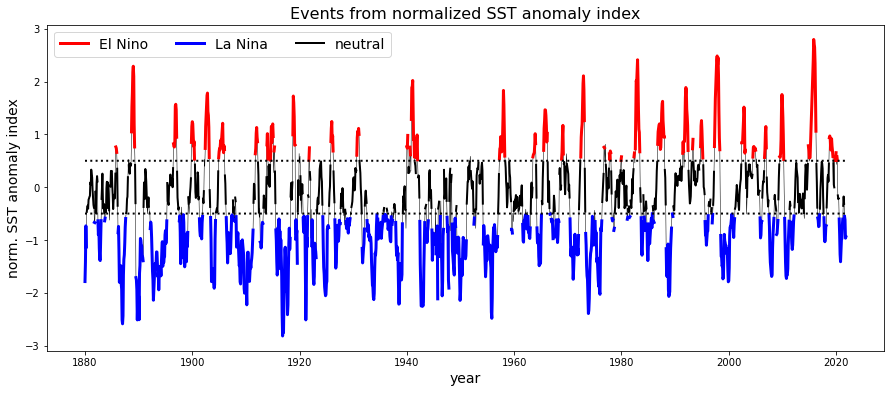

In [16]:
## Another way of highlighting distinct events:

# Mask events for plotting them in different colors
sst_ElNino = np.ma.masked_where(sst_anomaly_norm.values < 0.5, sst_anomaly_norm.values)
sst_LaNina = np.ma.masked_where(sst_anomaly_norm.values > -0.5, sst_anomaly_norm.values)
sst_neutral = np.ma.masked_where((sst_anomaly_norm.values >= 0.5) | (sst_anomaly_norm.values <= -0.5), sst_anomaly_norm.values)

# Focus on normalized ENSO index: Highlight events.
# > 0.5: EL Nino, < -0.5: La Nina, else: 'neutral'
fig, axes = plt.subplots(1, 1, figsize=(15,6))
axes.plot(sst_anomaly_norm.time, sst_anomaly_norm, color='black', linewidth=0.5)
axes.plot(sst_anomaly_norm.time, sst_ElNino, label='El Nino', color='red', linewidth=3)
axes.plot(sst_anomaly_norm.time, sst_LaNina, label='La Nina', color='blue', linewidth=3)
axes.plot(sst_anomaly_norm.time, sst_neutral, label='neutral', color='black', linewidth=2)

axes.set_xlabel("year", fontsize=14)
axes.set_ylabel("norm. SST anomaly index", fontsize=14)
axes.set_title("Events from normalized SST anomaly index", fontsize=16)
axes.legend(loc='upper left', ncol=4, fontsize=14)#, bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=4, fontsize=14)

# Add horizontal lines
axes.plot(sst_anomaly_norm.time,0.5 * np.ones(len(sst_anomaly_norm)),'k:', linewidth=2)
axes.plot(sst_anomaly_norm.time,-0.5 * np.ones(len(sst_anomaly_norm)),'k:', linewidth=2)

plt.show

### Discussion on samples' balance

We find class imbalance: Have a lot more La Nina samples than El Nino samples, at least in train data. This should not be a problem for ESN models, since we train output weights in a closed-form manner. And this is obviously another advantage compared to *regular* ANN architectures! 

If balance is required, we could think about **de-trending** sst anomaly index, but not done here.

### Classify sst anomaly fields (El Nino / La Nina) and try LRP

* linear Regression
* Multilayer Perceptron
* baseESN: Feed inputs column-wise into the model (using longitude as time dimension)

### Classification with linear regression on single continuous target

As **inputs** we use original size sst anomaly fields, capped, scaled to [-1,1] and flattened, **but only include valid gridpoints**. Use unscaled continuous normalized sst anomaly index as **target**.

Inputs have dimension (samples, 1, time steps), targets have timension (samples, 1). We are looking for weights $W$ with shape (time steps, 1) and bias $b$ as single value.

The relation between train inputs $U$, weights, bias and train targets $Y$ reads:

$$U \cdot W + \overline{b} = Y$$

Note: Here $\overline{b}$ denotes a vector of shape (samples, 1), containing only the single output bias value $b$.

We switch to "augmented" notation and include ${b}$ as additional weight in $W$. This requires to add a column of *ones* as last column of $U$, for keeping dimensions right. This leads to:

$$U' \cdot W' = Y$$

where $U'$ and $W'$ denote train inputs and weights in augmented notation, respectively. 

Solving for $W'$ we need to invert $U'$, or get the pseudo-inverse $U'_{inv}$, since $U'$ is usually not a square matrix:

$$W' = U'_{inv} \cdot Y$$

Doing this, we obtain trained weights (including bias) and stick to augmented notation. To get predictions on validation inputs we also need to add a column of *ones* as last column to validation inputs.


Lin. Regression, accuracy on sst anomaly fields from whole world: Continuous targets

train_acc_ElNino 1.0
train_acc_LaNina 1.0

val_acc_ElNino 1.0
val_acc_LaNina 1.0


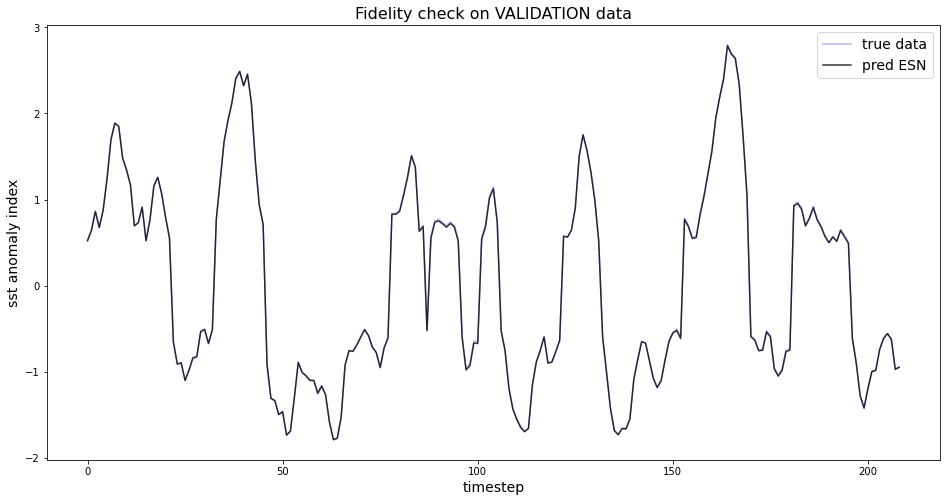

In [17]:
### Linear regression

# Create vector of shape (samples, 1) containing ONEs to be added as additional column to train and val inputs.
train_input_add = np.ones((train_input_flat.shape[0], 1))
val_input_add = np.ones((val_input_flat.shape[0], 1))

# Now add vector of ONEs as additional column to train and validation inputs, omit time dimension:
train_input_prime = np.concatenate((train_input_flat[:,0,:], train_input_add), axis=-1)
val_input_prime = np.concatenate((val_input_flat[:,0,:], val_input_add), axis=-1)

# Then need pseudo-inverse of train inputs in augmented notation
train_input_prime_inv = np.linalg.pinv(train_input_prime)

# Then get output weights, in augmented notation
W_prime = np.matmul(train_input_prime_inv, train_target)

# Get predictions on val and train data with trained weights:
val_pred_linReg = np.matmul(val_input_prime, W_prime)
train_pred_linReg = np.matmul(train_input_prime, W_prime)

## Get train and validation accuracy: Rel. amount of correctly predicted events.
## NOTE: We use kind of a one-dimensional soft-maxing. Having a positive / negative prediction value is already
## taken as El Nino / La Nina. In other words: Convert prediction to binary prediction.
val_acc_ElNino_linReg = sum(((val_pred_linReg>0)==(val_target>0.5)) & (val_target>0.5)) / sum((val_target>0.5))
val_acc_LaNina_linReg = sum(((val_pred_linReg<0)==(val_target<-0.5)) & (val_target<-0.5)) / sum((val_target<-0.5))
train_acc_ElNino_linReg = sum(((train_pred_linReg>0)==(train_target>0.5)) & (train_target>0.5)) / sum((train_target>0.5))
train_acc_LaNina_linReg = sum(((train_pred_linReg<0)==(train_target<-0.5)) & (train_target<-0.5)) / sum((train_target<-0.5))

# Print accuracies:
print("\nLin. Regression, accuracy on sst anomaly fields from whole world: Continuous targets")
print("\ntrain_acc_ElNino", np.round(train_acc_ElNino_linReg[0],2))
print("train_acc_LaNina", np.round(train_acc_LaNina_linReg[0],2))
print("\nval_acc_ElNino", np.round(val_acc_ElNino_linReg[0],2))
print("val_acc_LaNina", np.round(val_acc_LaNina_linReg[0],2))

# Fidelity check: Plot val_pred vs. val_targets
plt.figure(figsize=(16,8))
plt.plot(range(len(val_target[:])),val_target[:],'b',label="true data", alpha=0.3)
plt.plot(range(len(val_pred_linReg[:])),val_pred_linReg[:],'k',  alpha=0.8, label='pred ESN')
plt.title('Fidelity check on VALIDATION data', fontsize=16)
plt.xlabel('timestep', fontsize=14)
plt.ylabel('sst anomaly index', fontsize=14)
plt.legend(fontsize=14)
plt.show()

### Classification with multilayer perceptron (MLP)

As **inputs** we use original size sst anomaly fields, capped, scaled to [-1,1] and flattened, **but only include valid gridpoints**. Use unscaled continuous normalized sst anomaly index as **target**.

2022-09-21 09:07:09.662385: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-21 09:07:09.766772: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Model: "MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10988)]           0         
_________________________________________________________________
dense (Dense)                (None, 8)                 87912     
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 87,993
Trainable params: 87,993
Non-trainable params: 0
_________________________________________________________________


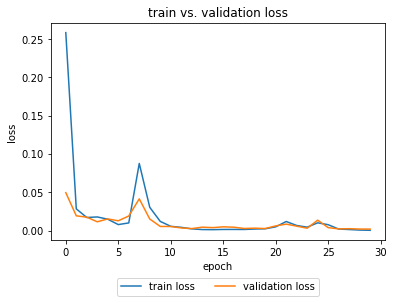

In [20]:
## Set parameters upfront:
lr = 0.0005 # Learning rate
epc = 30 # Number of epochs
batch_size = 10 # Batch size

# Set up layers:
inputs = Input(shape=(train_input_flat.shape[2]))
hidden_1 = Dense(8, activation='linear')(inputs)
hidden_2 = Dense(8, activation='linear')(hidden_1)
output = Dense(1, activation='linear')(hidden_2)

# Define and compile model :
model_MLP = Model(inputs, output, name='MLP')
opt = Adam(lr=lr) #SGD(lr=lr)
model_MLP.compile(loss='mse', optimizer=opt, metrics=['mse'])
model_MLP.summary()

## train model

# On capped inputs:
history = model_MLP.fit(train_input_flat[:,0,:], train_target, epochs=epc, verbose=0,
                    batch_size=batch_size, validation_data=(val_input_flat[:,0,:], val_target))

# Evaluate loss histories:
plt.plot(history.history['loss'], label='train loss'), 
plt.plot(history.history['val_loss'], label='validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('train vs. validation loss')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()


MLP, accuracy on sst anomaly fields from whole world: Continuous targets

train_acc_ElNino 1.0
train_acc_LaNina 1.0

val_acc_ElNino 1.0
val_acc_LaNina 1.0


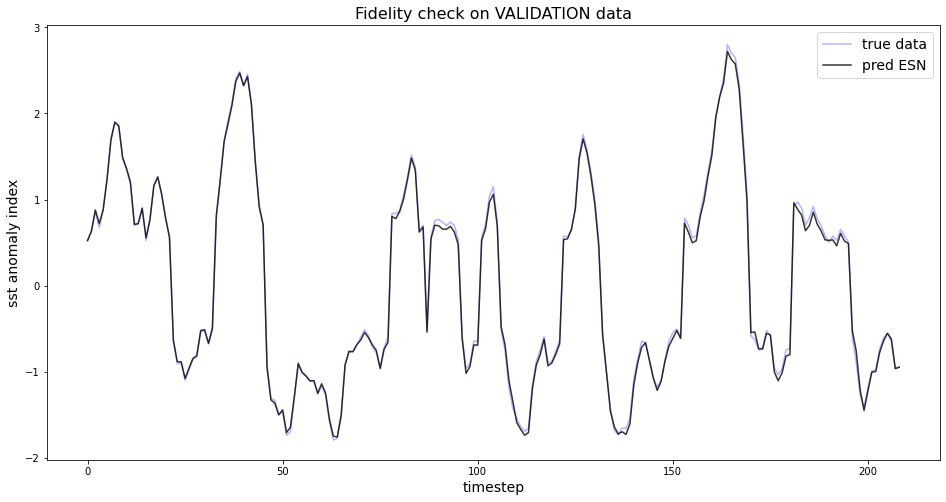

In [21]:
## Get model predictions on train and validation data:
train_pred_MLP = model_MLP.predict(train_input_flat[:,0,:])
val_pred_MLP = model_MLP.predict(val_input_flat[:,0,:])

## Get train and validation accuracy: Rel. amount of correctly predicted events.
## NOTE: We use kind of a one-dimensional soft-maxing. Having a positive / negative prediction value is already
## taken as El Nino / La Nina. In other words: Convert prediction to binary prediction.
val_acc_ElNino_MLP = sum(((val_pred_MLP>0)==(val_target>0.5)) & (val_target>0.5)) / sum((val_target>0.5))
val_acc_LaNina_MLP = sum(((val_pred_MLP<0)==(val_target<-0.5)) & (val_target<-0.5)) / sum((val_target<-0.5))
train_acc_ElNino_MLP = sum(((train_pred_MLP>0)==(train_target>0.5)) & (train_target>0.5)) / sum((train_target>0.5))
train_acc_LaNina_MLP = sum(((train_pred_MLP<0)==(train_target<-0.5)) & (train_target<-0.5)) / sum((train_target<-0.5))

# Print accuracies:
print("\nMLP, accuracy on sst anomaly fields from whole world: Continuous targets")
print("\ntrain_acc_ElNino", np.round(train_acc_ElNino_MLP[0],2))
print("train_acc_LaNina", np.round(train_acc_LaNina_MLP[0],2))
print("\nval_acc_ElNino", np.round(val_acc_ElNino_MLP[0],2))
print("val_acc_LaNina", np.round(val_acc_LaNina_MLP[0],2))

# Fidelity check: Plot val_pred vs. val_targets
plt.figure(figsize=(16,8))
plt.plot(range(len(val_target[:])),val_target[:],'b',label="true data", alpha=0.3)
plt.plot(range(len(val_pred_MLP[:])),val_pred_MLP[:],'k',  alpha=0.8, label='pred ESN')
plt.title('Fidelity check on VALIDATION data', fontsize=16)
plt.xlabel('timestep', fontsize=14)
plt.ylabel('sst anomaly index', fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [4]:
## Save trained MLP model:
# path_to_model = '../models/MLP'
# model_MLP.save(path_to_model)

## Reload trained MLP model:
# path_to_model = '../models/MLP'
# model_MLP = tf.keras.models.load_model(path_to_model)

### Classification with ESN (column-wise) on single continuous target

**Step 1:** Don't keep previous time steps reservoir states, which is equivalent to leakrate $\alpha=1$.

#### Base parameter setup

* n_res = 300
* W_in_lim = 0.1
* leak_rate = 1
* spec_radius = 0.8
* sparsity = 0.3

Use these parameters on normalmized sst anomaly fields, **capped**, **swapped longitude and latitude** and **scaled to [-1,1]** as inputs and **normalized sst anomaly index as single continuous target**, together with **tanh** activation.

In [24]:
### Try classification of sst anomaly fields with base ESN. Define parameters for ESN model upfront
verbose = True
input_length = train_input_swap.shape[1] # Number of input timesteps, directly taken from inputs' shape.
n_layers = 1 # Number of ESN layers in the model.
n_res = 300 # Number of reservoir units.
W_in_lim = 0.1 # Initialize input weights from random uniform distribution in [- W_in_lim, + W_in_lim]
leak_rate = 1 # Leak rate used in transition function of reservoir states.
leak_rate_first_step_YN = True # If true, multiply with alpha already in calculating first time stes's res. states.
leaky_integration_YN = True # If True, multiply previous time steps' reservoir states with (1-a).
                            # If False, omit multiplication with (1-a) in reservoir state transition. 
                            # But in any case still multiply new time steps' input (and reservoir recurrence) 
                            # with leakrate a after activation.
activation = 'tanh' # Desired activation function to be used in calculating reservoir state transition.
spec_radius = 0.8 # Spectral radius, becomes largest Eigenvalue of reservoir weight matrix.
sparsity = 0.3 # Sparsity of reservoir weight matrix.
in_features = train_input_swap.shape[2] # Number of input features, directly taken from inputs' shape.
out_features = 1 # E.g. 2 for classifying sst anomaly fields according to El Nino / La Nina events on one-hot targets.

/Users/mlandt-hayen/MarDATA/Python/ESN_ClassificationLRP_ENSO/notebooks/../src/models/ESN_functions.py:248: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())
/Users/mlandt-hayen/MarDATA/Python/ESN_ClassificationLRP_ENSO/notebooks/../src/models/ESN_functions.py:287: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 181, 89)]         0         
_________________________________________________________________
esn_2 (ESN)                  ((None, 181, 300), (None, 117300    
_________________________________________________________________
output (Dense)               (None, 1)                 301       
Total params: 117,601
Trainable params: 117,601
Non-trainable params: 0
_________________________________________________________________
Model: "model_short"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 181, 89)]         0         
_________________________________________________________________
esn_2 (ESN)                  ((None, 181, 300), (None, 117300    
Total params: 117,300
Trainable pa

/Users/mlandt-hayen/MarDATA/Python/ESN_ClassificationLRP_ENSO/notebooks/../src/models/ESN_functions.py:332: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())



shape of train input (samples, timesteps, input features):  (832, 181, 89)
shape of model output X_T (samples, n_res):  (832, 300)

Final reservoir states in augmented notation, shape:  (832, 301)

train_target shape (samples, output features):  (832, 1)

W_out shape:  (300, 1)
b_out shape:  (1,)

output feature  0 , trained b_out:  [-63.35162084]


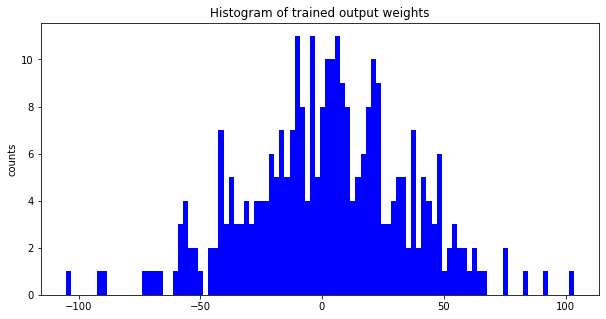


shape of val input (samples, time steps, features):  (209, 181, 89)
shape of train input (samples, time steps, features):  (832, 181, 89)

shape of model predictions on validation input (samples, 1):  (209, 1)
shape of val targets (samples, 1):  (209, 1)

train_mae:  0.4325
val_mae:  0.9139

train_mse:  0.3004
val_mse:  1.4939


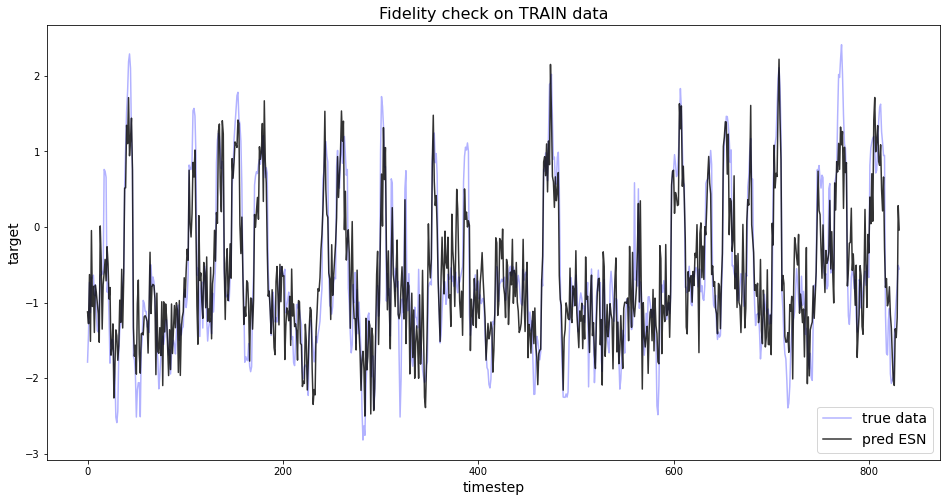

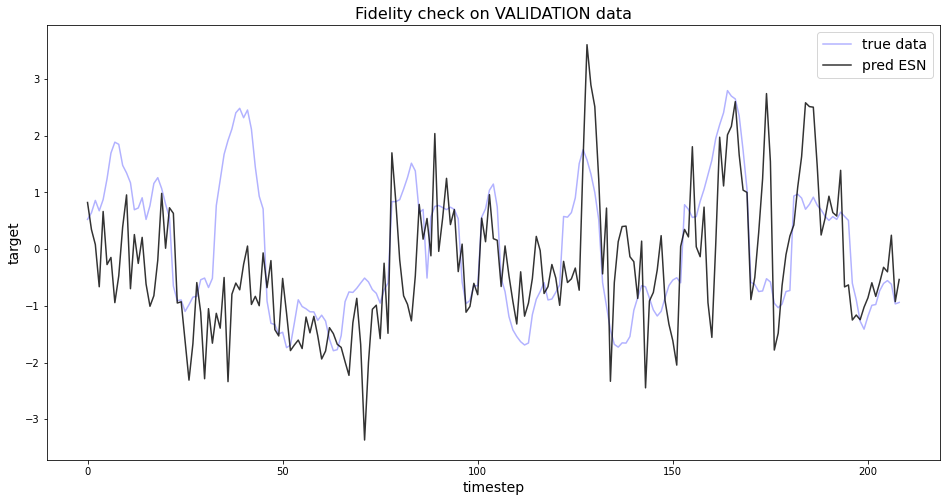

In [30]:
# Get complete model (output = target prediction) plus short model (output final reservoir states from all layers)
# and all_states (= another shortened model that gives reservoir states for ALL time steps for all inputs).
model, model_short, all_states = setESN(input_length=input_length, in_features=in_features,
                                        out_features=out_features, n_layers=n_layers,
                                        n_res=n_res, W_in_lim=W_in_lim, leak_rate=leak_rate,
                                        leak_rate_first_step_YN=leak_rate_first_step_YN,
                                        leaky_integration_YN = leaky_integration_YN,
                                        activation=activation, spec_radius=spec_radius,
                                        sparsity=sparsity, verbose=verbose)

# Train ESN model's output weights and bias
model = trainESN(model, model_short, train_input_swap, train_target, verbose=verbose)

# Get predictions from trained ESN model and evaluation metrics on model performance:
train_pred, val_pred, train_mae, val_mae, train_mse, val_mse = predESN(model, train_input_swap, val_input_swap,
                                                                       train_target, val_target,
                                                                       verbose=verbose)


ESN accuracy on sst anomaly fields from whole world: Continuous targets

train_acc_ElNino 0.84
train_acc_LaNina 0.96

val_acc_ElNino 0.36
val_acc_LaNina 0.84


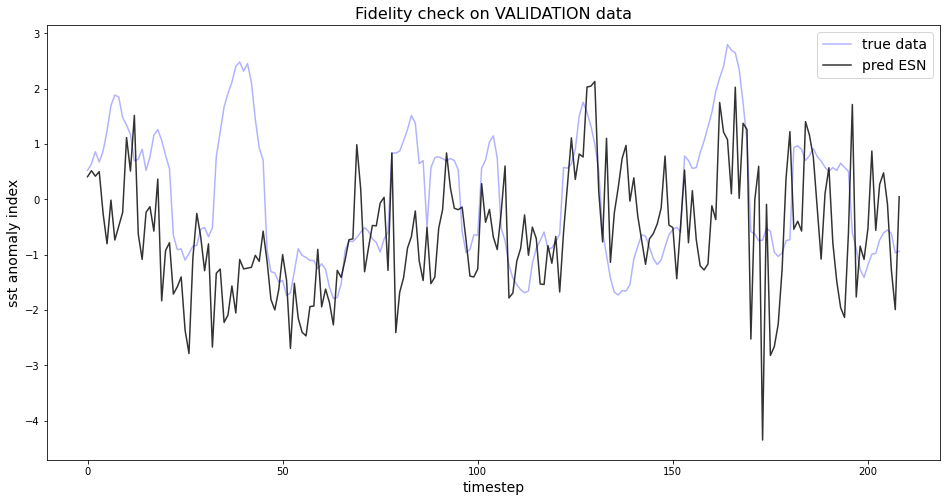

In [29]:
## Get model predictions on train and validation data:
train_pred = model.predict(train_input_swap[:,:,:])
val_pred = model.predict(val_input_swap[:,:,:])

## Get train and validation accuracy: Rel. amount of correctly predicted events.
## NOTE: We use kind of a one-dimensional soft-maxing. Having a positive / negative prediction value is already
## taken as El Nino / La Nina. In other words: Convert prediction to binary prediction.
val_acc_ElNino = sum(((val_pred>0)==(val_target>0.5)) & (val_target>0.5)) / sum((val_target>0.5))
val_acc_LaNina = sum(((val_pred<0)==(val_target<-0.5)) & (val_target<-0.5)) / sum((val_target<-0.5))
train_acc_ElNino = sum(((train_pred>0)==(train_target>0.5)) & (train_target>0.5)) / sum((train_target>0.5))
train_acc_LaNina = sum(((train_pred<0)==(train_target<-0.5)) & (train_target<-0.5)) / sum((train_target<-0.5))

# Print accuracies:
print("\nESN accuracy on sst anomaly fields from whole world: Continuous targets")
print("\ntrain_acc_ElNino", np.round(train_acc_ElNino[0],2))
print("train_acc_LaNina", np.round(train_acc_LaNina[0],2))
print("\nval_acc_ElNino", np.round(val_acc_ElNino[0],2))
print("val_acc_LaNina", np.round(val_acc_LaNina[0],2))

# Fidelity check: Plot val_pred vs. val_targets
plt.figure(figsize=(16,8))
plt.plot(range(len(val_target[:])),val_target[:],'b',label="true data", alpha=0.3)
plt.plot(range(len(val_pred[:])),val_pred[:],'k',  alpha=0.8, label='pred ESN')
plt.title('Fidelity check on VALIDATION data', fontsize=16)
plt.xlabel('timestep', fontsize=14)
plt.ylabel('sst anomaly index', fontsize=14)
plt.legend(fontsize=14)
plt.show()

### Classification with leaky integrator ESN (column-wise) on single continuous target

**Step 2:** Try leaky integrator ESN.

#### Base parameter setup

* n_res = 300
* W_in_lim = 0.1
* leak_rate = 0.01
* spec_radius = 0.8
* sparsity = 0.3

Use these parameters on normalmized sst anomaly fields, **capped**, **swapped longitude and latitude** and **scaled to [-1,1]** as inputs and **normalized sst anomaly index as single continuous target**, together with **tanh** activation.

In [31]:
### Try classification of sst anomaly fields with base ESN. Define parameters for ESN model upfront
verbose = True
input_length = train_input_swap.shape[1] # Number of input timesteps, directly taken from inputs' shape.
                                         # Optionally including dummy column of ONEs (if add_dummy_col=True).
n_layers = 1 # Number of ESN layers in the model.
n_res = 300 # Number of reservoir units.
W_in_lim = 0.1 # Initialize input weights from random uniform distribution in [- W_in_lim, + W_in_lim]
leak_rate = 0.01 # Leak rate used in transition function of reservoir states.
leak_rate_first_step_YN = True # If true, multiply with alpha already in calculating first timestes's res. states.
leaky_integration_YN = True # If True, multiply previous time steps' reservoir states with (1-a).
                            # If False, omit multiplication with (1-a) in reservoir state transition. 
                            # But in any case still multiply new time steps' input (and reservoir recurrence) 
                            # with leakrate a after activation.
activation = 'tanh' # Desired activation function to be used in calculating reservoir state transition.
spec_radius = 0.8 # Spectral radius, becomes largest Eigenvalue of reservoir weight matrix.
sparsity = 0.3 # Sparsity of reservoir weight matrix.
in_features = train_input_swap.shape[2] # Number of input features, directly taken from inputs' shape.
out_features = 1 # E.g. 2 for classifying sst anomaly fields according to El Nino / La Nina events on one-hot targets.

/Users/mlandt-hayen/MarDATA/Python/ESN_ClassificationLRP_ENSO/notebooks/../src/models/ESN_functions.py:248: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())
/Users/mlandt-hayen/MarDATA/Python/ESN_ClassificationLRP_ENSO/notebooks/../src/models/ESN_functions.py:287: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 181, 89)]         0         
_________________________________________________________________
esn_3 (ESN)                  ((None, 181, 300), (None, 117300    
_________________________________________________________________
output (Dense)               (None, 1)                 301       
Total params: 117,601
Trainable params: 117,601
Non-trainable params: 0
_________________________________________________________________
Model: "model_short"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 181, 89)]         0         
_________________________________________________________________
esn_3 (ESN)                  ((None, 181, 300), (None, 117300    
Total params: 117,300
Trainable pa

/Users/mlandt-hayen/MarDATA/Python/ESN_ClassificationLRP_ENSO/notebooks/../src/models/ESN_functions.py:332: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())



shape of train input (samples, timesteps, input features):  (832, 181, 89)
shape of model output X_T (samples, n_res):  (832, 300)

Final reservoir states in augmented notation, shape:  (832, 301)

train_target shape (samples, output features):  (832, 1)

W_out shape:  (300, 1)
b_out shape:  (1,)

output feature  0 , trained b_out:  [-14.96332013]


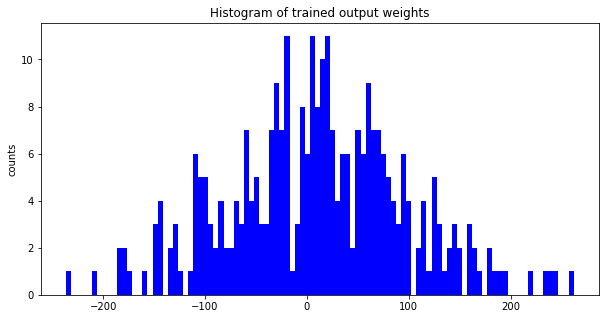


shape of val input (samples, time steps, features):  (209, 181, 89)
shape of train input (samples, time steps, features):  (832, 181, 89)

shape of model predictions on validation input (samples, 1):  (209, 1)
shape of val targets (samples, 1):  (209, 1)

train_mae:  0.0824
val_mae:  0.1958

train_mse:  0.0105
val_mse:  0.0783


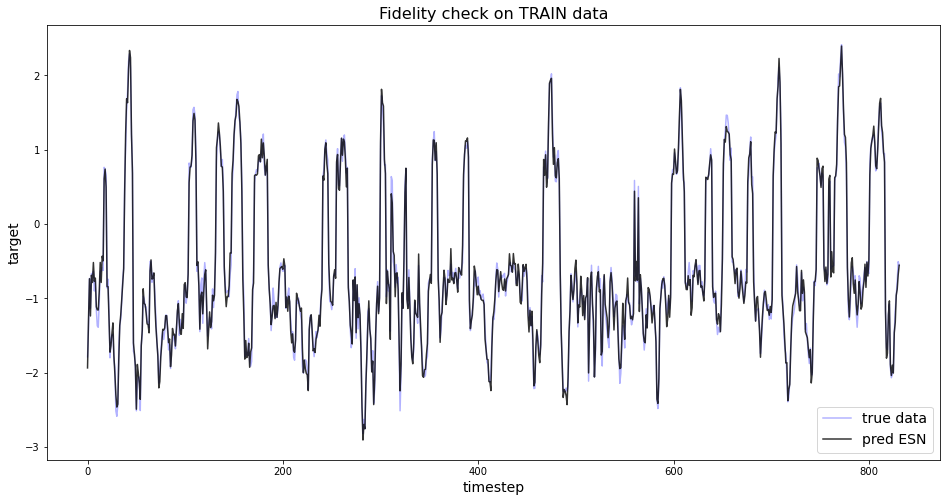

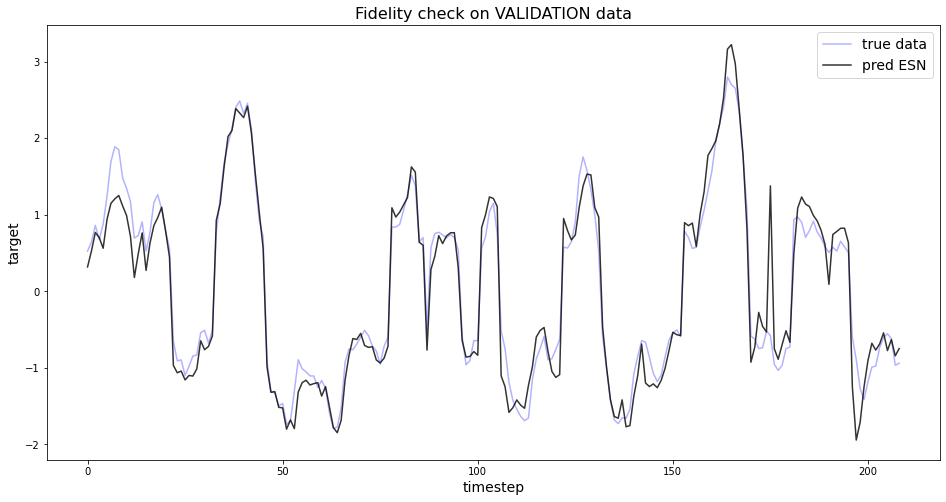

In [32]:
# Get complete model (output = target prediction) plus short model (output final reservoir states from all layers)
# and all_states (= another shortened model that gives reservoir states for ALL time steps for all inputs).
model, model_short, all_states = setESN(input_length=input_length, in_features=in_features,
                                        out_features=out_features, n_layers=n_layers,
                                        n_res=n_res, W_in_lim=W_in_lim, leak_rate=leak_rate,
                                        leak_rate_first_step_YN=leak_rate_first_step_YN,
                                        leaky_integration_YN = leaky_integration_YN,
                                        activation=activation, spec_radius=spec_radius,
                                        sparsity=sparsity, verbose=verbose)

# Train ESN model's output weights and bias
model = trainESN(model, model_short, train_input_swap, train_target, verbose=verbose)

# Get predictions from trained ESN model and evaluation metrics on model performance:
train_pred, val_pred, train_mae, val_mae, train_mse, val_mse = predESN(model, train_input_swap, val_input_swap,
                                                                       train_target, val_target,
                                                                       verbose=verbose)




 Leaky ESN accuracy on sst anomaly fields from whole world: Continuous targets

train_acc_ElNino 1.0
train_acc_LaNina 1.0

val_acc_ElNino 1.0
val_acc_LaNina 0.99


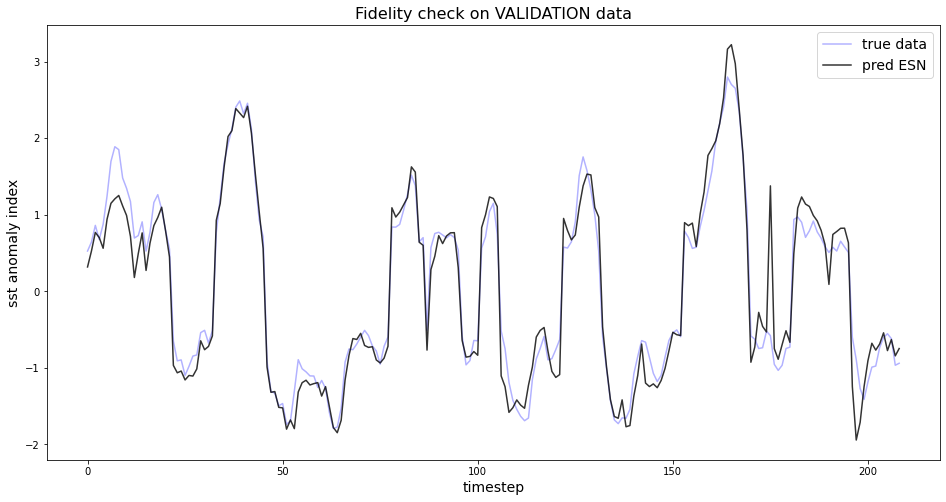

In [33]:
## Get model predictions on train and validation data:
train_pred = model.predict(train_input_swap[:,:,:])
val_pred = model.predict(val_input_swap[:,:,:])

## Get train and validation accuracy: Rel. amount of correctly predicted events.
## NOTE: We use kind of a one-dimensional soft-maxing. Having a positive / negative prediction value is already
## taken as El Nino / La Nina. In other words: Convert prediction to binary prediction.
val_acc_ElNino = sum(((val_pred>0)==(val_target>0.5)) & (val_target>0.5)) / sum((val_target>0.5))
val_acc_LaNina = sum(((val_pred<0)==(val_target<-0.5)) & (val_target<-0.5)) / sum((val_target<-0.5))
train_acc_ElNino = sum(((train_pred>0)==(train_target>0.5)) & (train_target>0.5)) / sum((train_target>0.5))
train_acc_LaNina = sum(((train_pred<0)==(train_target<-0.5)) & (train_target<-0.5)) / sum((train_target<-0.5))

# Print accuracies:
print("\n Leaky ESN accuracy on sst anomaly fields from whole world: Continuous targets")
print("\ntrain_acc_ElNino", np.round(train_acc_ElNino[0],2))
print("train_acc_LaNina", np.round(train_acc_LaNina[0],2))
print("\nval_acc_ElNino", np.round(val_acc_ElNino[0],2))
print("val_acc_LaNina", np.round(val_acc_LaNina[0],2))

# Fidelity check: Plot val_pred vs. val_targets
plt.figure(figsize=(16,8))
plt.plot(range(len(val_target[:])),val_target[:],'b',label="true data", alpha=0.3)
plt.plot(range(len(val_pred[:])),val_pred[:],'k',  alpha=0.8, label='pred ESN')
plt.title('Fidelity check on VALIDATION data', fontsize=16)
plt.xlabel('timestep', fontsize=14)
plt.ylabel('sst anomaly index', fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [35]:
## Save trained ESN model:
# path_to_model = '../models/ESN'
# model.save(path_to_model)

## Reload trained ESN model:
# path_to_model = '../models/ESN'
# model = tf.keras.models.load_model(path_to_model)

Sample dimensions and prediction:
raw sample shape (1, timesteps, features):  (1, 181, 89)
number of timesteps:  181
number of input features in_feat:  89
number of res. units n_res:  300
leak rate alpha:  0.01
model prediction on sample:  2.415

Model weights and biases, Dimensions:
input weights W_in (input features, res. units):  (89, 300)
input biases b_in (res. units):  (300,)
reservoir weights W_res (res. units, res. units):  (300, 300)
reservoir biases b_res (res. units):  (300,)
output weights W_out (res. units, output features):  (300, 1)
output biases b_out (output features):  (1,)


/var/folders/jv/p__lpnd50w93ff78f84hkwkh7fs9_f/T/ipykernel_1241/4121761455.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())



Tensor shapes:
input tensor U (timesteps, input features):  (181, 89)
all res. states X (timesteps, res. units):  (181, 300)
activations ACT (timesteps, res. units):  (181, 300)


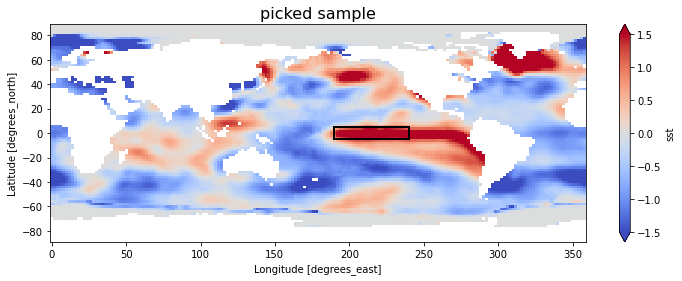

In [36]:
### Pick out one El Nino sample to be analysed:
sample_id = 41 # number 41 of validation inputs --> El Nino sample
#sample_id = 52 # number 52 of validation inputs --> La Nina sample
sample = val_input_swap[sample_id:sample_id+1,:,:]

# Plot sample input
fig, ax = plt.subplots(figsize=(12, 4))
sst_anomaly_fields_NinoNina[sample_id].name = 'sst anomaly deg Celsius'
sst_anomaly_fields_NinoNina[sample_id].plot(ax=ax, cmap='coolwarm', vmax=1.5, vmin=-1.5)
plt.title('picked sample', fontsize=16)

# Create a Rectangle patch and add the patch to the Axes
rect = patches.Rectangle((190, -5), 50, 10, linewidth=2, edgecolor='black', facecolor='none')
ax.add_patch(rect)

# Extract number of time steps (time steps) and variable T to loop over.
# Note: Subtract 1 from absolute number of timesteps to get T, since loops start at 0.
timesteps = sample.shape[1]
T = timesteps - 1

# Extract number of input features:
in_feat = sample.shape[2]

# Rename leak_rate to 'a' for convenience and readability of LRP algorithm:
a = leak_rate

# Have trained model as pre-requisite. For BOTH output units (El Nino / La Nina) check prediction on picked sample:
pred = model.predict(sample)

## Check dimensions and prediction:
print("Sample dimensions and prediction:")
print("=================================")
print("raw sample shape (1, timesteps, features): ", sample.shape)
print("number of timesteps: ", timesteps)
print("number of input features in_feat: ", in_feat)
print("number of res. units n_res: ", n_res)
print("leak rate alpha: ", a)
print("model prediction on sample: ", np.round(pred[0,0],3))

### Extract model weights from trained model:

## Get all weights:
model_weights = np.array(model.get_weights())

## Set input / reservoir / output weights and bias(es):
W_in = model_weights[0]
b_in = model_weights[1]
W_res = model_weights[2]
b_res = model_weights[3]
W_out = model_weights[4]
b_out = model_weights[5]

## Check dimensions:
print("\nModel weights and biases, Dimensions:")
print("=====================================")
print("input weights W_in (input features, res. units): ", W_in.shape)
print("input biases b_in (res. units): ", b_in.shape)
print("reservoir weights W_res (res. units, res. units): ", W_res.shape)
print("reservoir biases b_res (res. units): ", b_res.shape)
print("output weights W_out (res. units, output features): ", W_out.shape)
print("output biases b_out (output features): ", b_out.shape)

## Set tensors for inputs U, activation layer ACT and all reservoir states X:

# Get inputs U for all timesteps from raw input sample by just omitting first dimension (=sample number):
U = sample[0,:,:]

# Get all reservoir states for all timesteps X on picked sample, omit first dimension (=sample number):
X = all_states.predict(sample)[0,:,:]

# Get X' from all reservoir states X, shifted by one timestep and adding ZEROs as first row:
X_prime = np.concatenate([np.zeros((1,n_res)),X[:-1,:]], axis=0)

# Get activation layer ACT from relation: X = (1 - alpha) * X_prime + alpha * ACT
ACT = (X - (1 - a) * X_prime) / a

# Check dimensions:
print("\nTensor shapes:")
print("==============")
print("input tensor U (timesteps, input features): ", U.shape)
print("all res. states X (timesteps, res. units): ", X.shape)
print("activations ACT (timesteps, res. units): ", ACT.shape)

In [37]:
### LRP on baseESN (col-wise): Only take positive contributions of pre-activations into account.
### EL NINO

## Start with final layer T

# Get relevances R_i and first part of R_j for n_res units x_i in ACT(T) and x_j in X(T-1), respectively,
# connecting to OUTPUT unit x_o:
R_i = (a * (np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0]) /
       sum((np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0])) * pred[0,0])
R_j_1 = ((1 - a) * (np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0])
         / sum((np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0])) * pred[0,0])

# Get relevances R_k for in_feat input units x_k of U(T)
R_k = np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)
             / (np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in), axis=0)
                + np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

# Get second contribution R_j_2 for relevance R_j for n_res units x_j of X(T-1) connecting to x_i units of ACT(T).
R_j_2 = np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)
/ (np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in), axis=0)
                + np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

# Combine both contributions for relevance R_j, for n_res units x_j of X(T-1):
R_j = R_j_1 + R_j_2

## Store relevance for input layer U for current timestep.
R_all = np.reshape(R_k,(1,len(R_k)))

# Store other relevances for plausibility check:
R_i_sum = []
R_j_sum = []
R_k_sum = []
R_j_1_sum = []
R_j_2_sum = []
R_i_sum.append(sum(R_i))
R_j_sum.append(sum(R_j))
R_k_sum.append(sum(R_k))
R_j_1_sum.append(sum(R_j_1))
R_j_2_sum.append(sum(R_j_2))

### Now loop over remaining T-1 layers in decreasing order. Start with T-1, stop at 1, since we need
### special treatment there!


for t in np.flip(np.arange(1,T)):
    
    # Get relevances R_i for n_res units x_i of ACT(t). Note: Each unit x_i is only connected to a
    # single corresponding unit x_m of X(t), multiplied by alpha. 
    # No additional weights and bias in this connection, hence w=1 and b=0.
    R_i = a * R_j
    
    # The same holds true for first part of relevances R_j_1 for n_res units x_j of X(t-1) connecting to
    # n_res units x_m of X(t), multiplied by (1-alpha), no weights and bias.
    R_j_1 = (1 - a) * R_j
    
    # Get relevances R_k for in_feat input units x_k of U(T)
    R_k = np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)
                 / (np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in), axis=0)
                    + np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

    # Get second contribution R_j_2 for relevance R_j for n_res units x_j of X(T-1) connecting to x_i units of ACT(T).
    R_j_2 = np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)
    / (np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in), axis=0)
                    + np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)
    
    # Combine both contributions for relevance R_j, for n_res units x_j of X(t-1):
    R_j = R_j_1 + R_j_2

    ## Store relevance for input layer U for current timestep.
    R_all = np.concatenate([np.reshape(R_k,(1,len(R_k))), R_all], axis=0)
    
    # Store other relevances for plausibility check:
    R_i_sum.append(sum(R_i))
    R_j_sum.append(sum(R_j))
    R_k_sum.append(sum(R_k))
    R_j_1_sum.append(sum(R_j_1))
    R_j_2_sum.append(sum(R_j_2))

## Now take care of time step t=1: This time step is related to the dummy column of ONEs, we added to the
## input samples as first column to absorb residual relevance in order to preserve total relevance
## without influencing prediction accuracy.

# Note: There is no previous time step's reservoir states X(t=0).   
# Hence ACT(1) equals X(1). No multiplication with alpha!
R_i = R_j

# And lastly the residual relevance R_i is completely distributed on first time step's inputs U(1):
R_k = np.sum((np.multiply(np.reshape(U[0,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[0,:],(in_feat,1)),W_in)
                 / (np.sum((np.multiply(np.reshape(U[0,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[0,:],(in_feat,1)),W_in), axis=0)) * R_i, axis=1)

## Store relevance for input layer U for time step t=1.
R_all = np.concatenate([np.reshape(R_k,(1,len(R_k))), R_all], axis=0)
R_k_sum.append(sum(R_k))
   
## Since we worked with swapped sample (lat <-> lon), reverse swapping:
R_all_1pos = np.swapaxes(R_all, 0, 1)

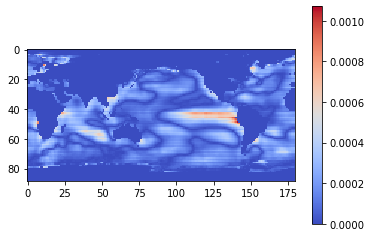

In [55]:
## Plot relevance map OMITTING dummy column, which only serves for capturing residual relevance:

# baseESN, feed inputs col-wise, tanh activation, alpha = 0.01
# Relevance heatmap for single El Nino sample, CAPPED inputs (cap_limits = [-5, 5]), scaled to [-1,1]
# Single continuous normalized sst anomaly index as target.
plt.imshow(R_all_1pos[:,1:], cmap='coolwarm', interpolation='nearest')#, vmin=0, vmax=0.002)
plt.colorbar()
plt.show()

### baseESN (column-wise): Get mean relevance maps for all El Nino (from train inputs)

In [56]:
### LRP with baseESN on ALL El Nino (from train inputs)

verbose=False

## Split train inputs into El Nino / La Nina samples, according to binary target:
samples_ElNino = train_input_swap[(train_target_bin==1)[:,0]]
samples_LaNina = train_input_swap[(train_target_bin==0)[:,0]]

## Split targets accordingly:
targets_ElNino = train_target[(train_target_bin==1)[:,0]]

if verbose:
    print("samples_ElNino shape: ", samples_ElNino.shape)
    print("samples_LaNina shape: ", samples_LaNina.shape)

# Extract number of time steps (timesteps) and variable T to loop over.
# Note: Subtract 1 from absolute number of timesteps to get T, since loops start at 0.
timesteps = samples_ElNino.shape[1]
T = timesteps - 1

# Extract number of input features:
in_feat = samples_ElNino.shape[2]

# Rename leak_rate to 'a' for convenience and readability of LRP algorithm:
a = leak_rate

### Extract model weights from trained model:

## Get all weights:
model_weights = np.array(model.get_weights())

## Set input / reservoir / output weights and bias(es):
W_in = model_weights[0]
b_in = model_weights[1]
W_res = model_weights[2]
b_res = model_weights[3]
W_out = model_weights[4]
b_out = model_weights[5]

## Initialize storage for mean relevance over all ElNino samples.
R_all_mean = np.zeros((T+1, in_feat))
    
#Loop over El Nino samples:
for sample_id in range(len(samples_ElNino)):
    
    # Print status:
    print ("sample: ", sample_id+1, " from ", len(samples_ElNino))
    
    # Get current sample:
    sample = samples_ElNino[sample_id:sample_id+1]
    
    # Have trained model as pre-requisite. Check prediction and target on picked sample:
    pred = model.predict(sample)[0,0]
    
    ## Set tensors for inputs U, activation layer ACT and all reservoir states X:

    # Get inputs U for all timesteps from raw input sample by just omitting first dimension (=sample number):
    U = sample[0,:,:]

    # Get all reservoir states for all timesteps X on picked sample, omit first dimension (=sample number):
    X = all_states.predict(sample)[0,:,:]

    # Get X' from all reservoir states X, shifted by one timestep and adding ZEROs as first row:
    X_prime = np.concatenate([np.zeros((1,n_res)),X[:-1,:]], axis=0)

    # Get activation layer ACT from relation: X = (1 - alpha) * X_prime + alpha * ACT
    ACT = (X - (1 - a) * X_prime) / a
    
    ### LRP on baseESN: Second attempt, only consider positive contributions of pre-potential into account.

    ## Start with layer T

    # Get relevances R_i and first part of R_j for n_res units x_i in ACT(T) and x_j in X(T-1), respectively,
    # connecting to single OUTPUT unit x_o:
    R_i = (a * (np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0]) /
           sum((np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0])) * pred)
    R_j_1 = ((1 - a) * (np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0])
             / sum((np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0])) * pred)

    # Get relevances R_k for in_feat input units x_k of U(T)
    R_k = np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)
                 / (np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in), axis=0)
                    + np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

    # Get second contribution R_j_2 for relevance R_j for n_res units x_j of X(T-1) connecting to x_i units of ACT(T).
    R_j_2 = np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)
    / (np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in), axis=0)
                    + np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

    # Combine both contributions for relevance R_j, for n_res units x_j of X(T-1):
    R_j = R_j_1 + R_j_2

    ## Store relevance for input layer U for current time step.
    R_all = np.reshape(R_k,(1,len(R_k)))

    ### Now loop over remaining T-1 layers in decreasing order. Start with T-1, stop at 1, since we need
    ### special treatment there!


    for t in np.flip(np.arange(1,T)):

        # Get relevances R_i for n_res units x_i of ACT(t). Note: Each unit x_i is only connected to a
        # single corresponding unit x_m of X(t), multiplied by alpha. 
        # No additional weights and bias in this connection, hence w=1 and b=0.
        R_i = a * R_j

        # The same holds true for first part of relevances R_j_1 for n_res units x_j of X(t-1) connecting to
        # n_res units x_m of X(t), multiplied by (1-alpha), no weights and bias.
        R_j_1 = (1 - a) * R_j

        # Get relevances R_k for in_feat input units x_k of U(T)
        R_k = np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)
                     / (np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in), axis=0)
                        + np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

        # Get second contribution R_j_2 for relevance R_j for n_res units x_j of X(T-1) connecting to x_i units of ACT(T).
        R_j_2 = np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)
        / (np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in), axis=0)
                        + np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

        # Combine both contributions for relevance R_j, for n_res units x_j of X(t-1):
        R_j = R_j_1 + R_j_2

        ## Store relevance for input layer U for current timestep.
        R_all = np.concatenate([np.reshape(R_k,(1,len(R_k))), R_all], axis=0)

        
    ## Now take care of time step t=1: This time step is related to the dummy column of ONEs, we added to the
    ## input samples as first column to absorb residual relevance in order to preserve total relevance
    ## without influencing prediction accuracy.

    # Note: There is no previous time step's reservoir states X(t=0).   
    # Hence ACT(1) equals X(1). No multiplication with alpha!
    R_i = R_j

    # And lastly the residual relevance R_i is completely distributed on first time step's inputs U(1):
    R_k = np.sum((np.multiply(np.reshape(U[0,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[0,:],(in_feat,1)),W_in)
                     / (np.sum((np.multiply(np.reshape(U[0,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[0,:],(in_feat,1)),W_in), axis=0)) * R_i, axis=1)

    ## Store relevance for input layer U for very first time step (t=1).
    R_all = np.concatenate([np.reshape(R_k,(1,len(R_k))), R_all], axis=0)
        
    ## Add relevance for current sample to storage for ALL samples:
    R_all_mean += R_all

## Get mean relevance over ALL samples:
R_all_mean = R_all_mean / len(samples_ElNino)

## Since we worked with swapped sample (lat <-> lon), reverse swapping:
R_all_mean_nino = np.swapaxes(R_all_mean, 0, 1)

/var/folders/jv/p__lpnd50w93ff78f84hkwkh7fs9_f/T/ipykernel_1241/3849119468.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())


sample:  1  from  195
sample:  2  from  195
sample:  3  from  195
sample:  4  from  195
sample:  5  from  195
sample:  6  from  195
sample:  7  from  195
sample:  8  from  195
sample:  9  from  195
sample:  10  from  195
sample:  11  from  195
sample:  12  from  195
sample:  13  from  195
sample:  14  from  195
sample:  15  from  195
sample:  16  from  195
sample:  17  from  195
sample:  18  from  195
sample:  19  from  195
sample:  20  from  195
sample:  21  from  195
sample:  22  from  195
sample:  23  from  195
sample:  24  from  195
sample:  25  from  195
sample:  26  from  195
sample:  27  from  195
sample:  28  from  195
sample:  29  from  195
sample:  30  from  195
sample:  31  from  195
sample:  32  from  195
sample:  33  from  195
sample:  34  from  195
sample:  35  from  195
sample:  36  from  195
sample:  37  from  195
sample:  38  from  195
sample:  39  from  195
sample:  40  from  195
sample:  41  from  195
sample:  42  from  195
sample:  43  from  195
sample:  44  from  1

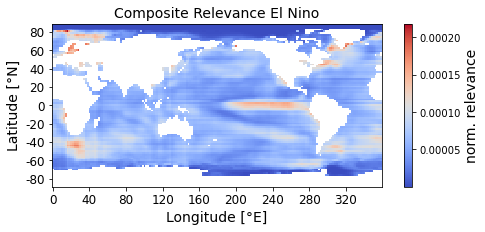

In [59]:
# Omit dummy column, which only served for capturing residual relevance:
R_all_mean_nino = R_all_mean_nino[:,1:]

# Set former NaN values to NaN, to highlight land masses:
R_all_mean_nino[temp_isnan[0]] = float("nan")

# baseESN, feed inputs col-wise into model, tanh activation, alpha = 0.01, 
# Mean relevance heatmap El Nino, CAPPED inputs (cap_limits = [-5, 5]), scaled to [-1,1]
# Single continuous normalized sst anomaly index as target.

## Plot mean relevance map over ALL El Nino samples, with bounding box arround Nino3.4 area
fig, ax = plt.subplots(figsize=(8, 3))

im = plt.imshow(R_all_mean_nino, cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label("norm. relevance", fontsize=14)

plt.title('Composite Relevance El Nino', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 180, step=20), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([4, 14, 24, 34, 44, 54, 64, 74, 84], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

# Create a Rectangle patch and add the patch to the Axes
#rect = patches.Rectangle((95, 41), 25, 6, linewidth=2, edgecolor='black', facecolor='none')
#ax.add_patch(rect)

plt.show()

### Investigate robustness of col-wise base ESN on permuting inputs

sst anomaly is found to have a strong **zonal** character. Feeding inputs column-wise into the model, we support this zonal structure, because each latitude is fed into the model as one long time series of 180 steps (= longitude).

We now want to investigate, if our approach is robust against permutation of input gridpoints: For each row we apply some random (but reversible!) permutation of gridpoints.

Then check accuracy and restore (reverse permutation!) relevance map: Does the model still find Nino region to be most relevant?

**Note:** While preprocessing input data, we added a **dummy column** of *ONEs* as first column to swapped inputs. Need to remove this dummy column before permuting inputs and then again add former dummy column as **first column to permuted inputs**. This is required, since we want the dummy column to capture residual relevance.

In [62]:
# Get random permutation of number of timesteps (here longitude dimension).
# Omit dummy column!
rand_perm = np.random.permutation(train_input_swap[:,1:,:].shape[1])

In [63]:
## Now apply this permutation to validation and train inputs:

# Initialize storage (samples, time steps, features).
# Omit dummy column!
val_input_swap_perm = np.zeros(val_input_swap[:,1:,:].shape)
train_input_swap_perm = np.zeros(train_input_swap[:,1:,:].shape)

## Validation inputs: 

# Loop over number of samples:
for sample in range(val_input_swap.shape[0]):
    
    # Loop over number of features:
    for feat in range(val_input_swap.shape[2]):
        
        # Store permutation:
        val_input_swap_perm[sample,:,feat] = val_input_swap[:,1:,:][sample,rand_perm,feat]
        
## Train inputs: 

# Loop over number of samples:
for sample in range(train_input_swap.shape[0]):
    
    # Loop over number of features:
    for feat in range(train_input_swap.shape[2]):
        
        # Store permutation:
        train_input_swap_perm[sample,:,feat] = train_input_swap[:,1:,:][sample,rand_perm,feat]

In [64]:
## Now reverse permutation on validation inputs:

# Initialize storage (samples, timesteps, features):
val_input_swap_perm_rev = np.zeros(val_input_swap_perm.shape)

# Get reverse permutation from argsort:
perm_rev = np.argsort(rand_perm)

# Loop over number of samples:
for sample in range(val_input_swap_perm.shape[0]):
    
    # Loop over number of features:
    for feat in range(val_input_swap_perm.shape[2]):
        
        # Store permutation:
        val_input_swap_perm_rev[sample,:,feat] = val_input_swap_perm[sample,perm_rev,feat]

In [65]:
## Now apply this permutation on composite El Nino sample:

# Initialize storage (timesteps, features):
sst_anomaly_mean_ElNino_perm = np.zeros(sst_anomaly_mean_ElNino.values.shape)

# Loop over number of features:
for feat in range(sst_anomaly_mean_ElNino_perm.shape[0]):

    # Store permutation:
    sst_anomaly_mean_ElNino_perm[feat,:] = sst_anomaly_mean_ElNino.values[feat,rand_perm]
  

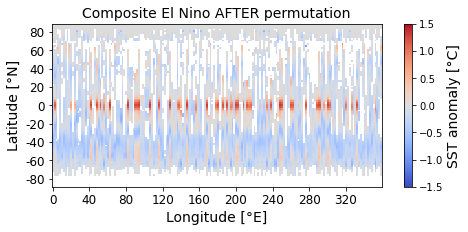

In [66]:
# baseESN, feed inputs col-wise into model, tanh activation, alpha = 0.01, 
# Mean relevance heatmap El Nino, CAPPED inputs (cap_limits = [-5, 5]), scaled to [-1,1]
# Single continuous normalized sst anomaly index as target.

## Plot mean relevance map over ALL El Nino samples, with bounding box arround Nino3.4 area
fig, ax = plt.subplots(figsize=(8, 3))

im = plt.imshow(sst_anomaly_mean_ElNino_perm, cmap="coolwarm", interpolation='nearest', vmin=-1.5, vmax=1.5)
cbar = plt.colorbar(im)
cbar.set_label("SST anomaly [°C]", fontsize=14)

plt.title('Composite El Nino AFTER permutation', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 180, step=20), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([4, 14, 24, 34, 44, 54, 64, 74, 84], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

# Create a Rectangle patch and add the patch to the Axes
#rect = patches.Rectangle((95, 41), 25, 6, linewidth=2, edgecolor='black', facecolor='none')
#ax.add_patch(rect)

plt.show()

### Train baseESN model (col-wise) on permuted inputs

In [69]:
# Add dummy column of ONEs as first column to every permuted train and validation sample.
train_input_swap_perm = np.concatenate([np.ones((832,1,89)), train_input_swap_perm], axis=1) 
val_input_swap_perm = np.concatenate([np.ones((209,1,89)), val_input_swap_perm], axis=1) 

In [71]:
### Try classification of sst anomaly fields with base ESN. Define parameters for ESN model upfront
verbose = True
input_length = train_input_swap_perm.shape[1] # Number of input timesteps, directly taken from inputs' shape.
n_layers = 1 # Number of ESN layers in the model.
n_res = 300 # Number of reservoir units.
W_in_lim = 0.1 # Initialize input weights from random uniform distribution in [- W_in_lim, + W_in_lim]
leak_rate = 0.01 # Leak rate used in transition function of reservoir states.
leak_rate_first_step_YN = True # If true, multiply with alpha already in calculating first time stes's res. states.
leaky_integration_YN = True # If True, multiply previous time steps' reservoir states with (1-a).
                            # If False, omit multiplication with (1-a) in reservoir state transition. 
                            # But in any case still multiply new time steps' input (and reservoir recurrence) 
                            # with leakrate a after activation.
activation = 'tanh' # Desired activation function to be used in calculating reservoir state transition.
spec_radius = 0.8 # Spectral radius, becomes largest Eigenvalue of reservoir weight matrix.
sparsity = 0.3 # Sparsity of reservoir weight matrix.
in_features = train_input_swap_perm.shape[2] # Number of input features, directly taken from inputs' shape.
out_features = 1 # E.g. 2 for classifying sst anomaly fields according to El Nino / La Nina events on one-hot targets.

/Users/mlandt-hayen/MarDATA/Python/ESN_ClassificationLRP_ENSO/notebooks/../src/models/ESN_functions.py:248: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())
/Users/mlandt-hayen/MarDATA/Python/ESN_ClassificationLRP_ENSO/notebooks/../src/models/ESN_functions.py:287: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 181, 89)]         0         
_________________________________________________________________
esn_4 (ESN)                  ((None, 181, 300), (None, 117300    
_________________________________________________________________
output (Dense)               (None, 1)                 301       
Total params: 117,601
Trainable params: 117,601
Non-trainable params: 0
_________________________________________________________________
Model: "model_short"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 181, 89)]         0         
_________________________________________________________________
esn_4 (ESN)                  ((None, 181, 300), (None, 117300    
Total params: 117,300
Trainable pa

/Users/mlandt-hayen/MarDATA/Python/ESN_ClassificationLRP_ENSO/notebooks/../src/models/ESN_functions.py:332: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())



shape of train input (samples, timesteps, input features):  (832, 181, 89)
shape of model output X_T (samples, n_res):  (832, 300)

Final reservoir states in augmented notation, shape:  (832, 301)

train_target shape (samples, output features):  (832, 1)

W_out shape:  (300, 1)
b_out shape:  (1,)

output feature  0 , trained b_out:  [-3.91055107]


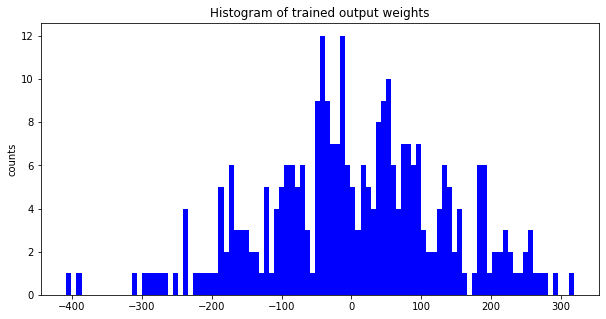


shape of val input (samples, time steps, features):  (209, 181, 89)
shape of train input (samples, time steps, features):  (832, 181, 89)

shape of model predictions on validation input (samples, 1):  (209, 1)
shape of val targets (samples, 1):  (209, 1)

train_mae:  0.0735
val_mae:  0.1845

train_mse:  0.0083
val_mse:  0.0641


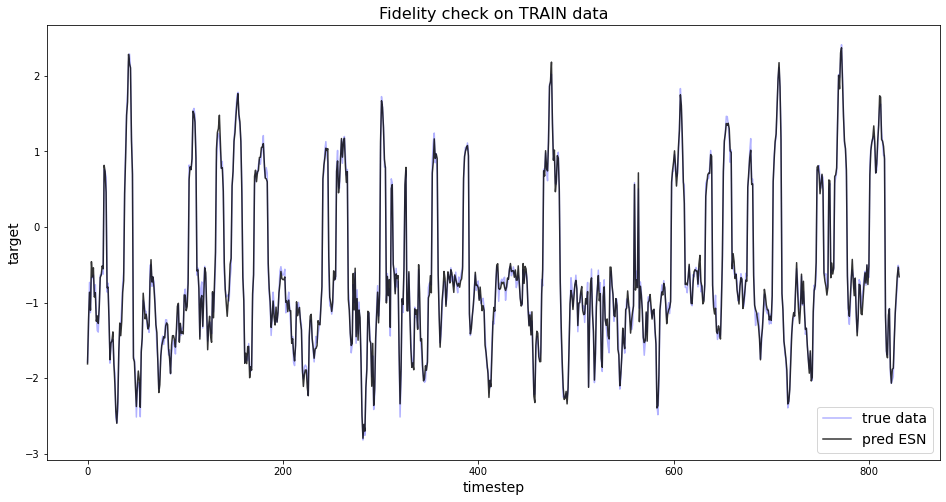

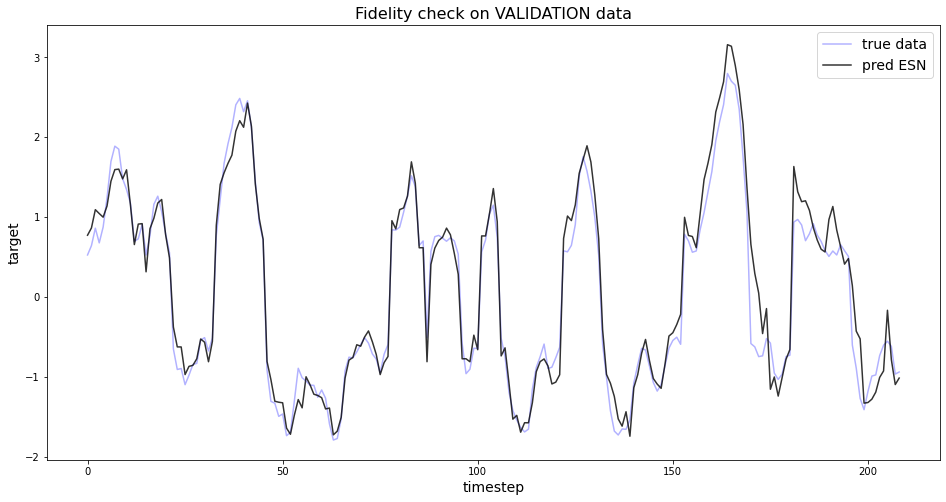

In [74]:
# Get complete model (output = target prediction) plus short model (output final reservoir states from all layers)
# and all_states (= another shortened model that gives reservoir states for ALL timesteps for all inputs).
model_perm, model_short_perm, all_states_perm = setESN(input_length=input_length, in_features=in_features,
                                        out_features=out_features, n_layers=n_layers,
                                        n_res=n_res, W_in_lim=W_in_lim, leak_rate=leak_rate,
                                        leak_rate_first_step_YN=leak_rate_first_step_YN,
                                        leaky_integration_YN=leaky_integration_YN,
                                        activation=activation, spec_radius=spec_radius,
                                        sparsity=sparsity, verbose=verbose)

# Train ESN model's output weights and bias
model_perm = trainESN(model_perm, model_short_perm, train_input_swap_perm, train_target, verbose=verbose)

# Get predictions from trained ESN model and evaluation metrics on model performance:
train_pred, val_pred, train_mae, val_mae, train_mse, val_mse = predESN(model_perm, train_input_swap_perm,
                                                                       val_input_swap_perm,
                                                                       train_target, val_target,
                                                                       verbose=verbose)


MLP, accuracy on sst anomaly fields from whole world: Continuous targets

train_acc_ElNino 1.0
train_acc_LaNina 1.0

val_acc_ElNino 1.0
val_acc_LaNina 0.96


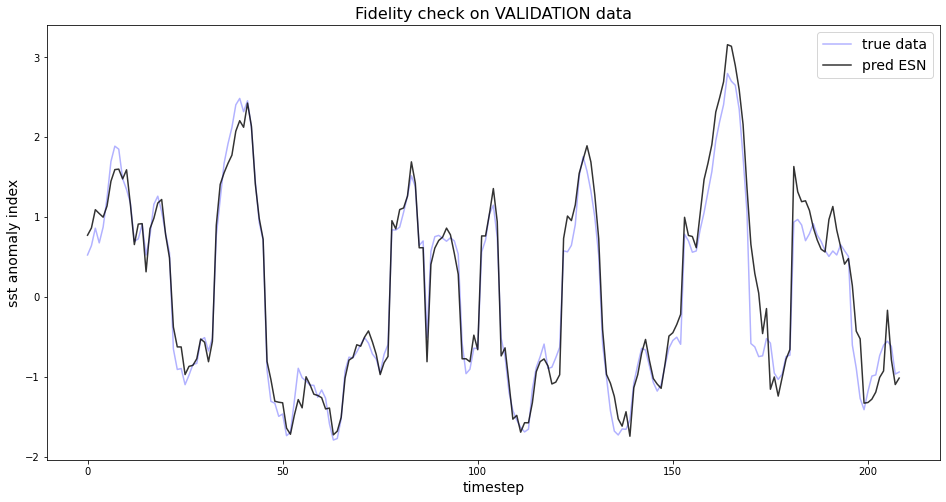

In [75]:
## Get model predictions on train and validation data:
train_pred_perm = model_perm.predict(train_input_swap_perm[:,:,:])
val_pred_perm = model_perm.predict(val_input_swap_perm[:,:,:])

## Get train and validation accuracy: Rel. amount of correctly predicted events.
## NOTE: We use kind of a one-dimensional soft-maxing. Having a positive / negative prediction value is already
## taken as El Nino / La Nina. In other words: Convert prediction to binary prediction.
val_acc_ElNino_perm = sum(((val_pred_perm>0)==(val_target>0.5)) & (val_target>0.5)) / sum((val_target>0.5))
val_acc_LaNina_perm = sum(((val_pred_perm<0)==(val_target<-0.5)) & (val_target<-0.5)) / sum((val_target<-0.5))
train_acc_ElNino_perm = sum(((train_pred_perm>0)==(train_target>0.5)) & (train_target>0.5)) / sum((train_target>0.5))
train_acc_LaNina_perm = sum(((train_pred_perm<0)==(train_target<-0.5)) & (train_target<-0.5)) / sum((train_target<-0.5))

# Print accuracies:
print("\nMLP, accuracy on sst anomaly fields from whole world: Continuous targets")
print("\ntrain_acc_ElNino", np.round(train_acc_ElNino_perm[0],2))
print("train_acc_LaNina", np.round(train_acc_LaNina_perm[0],2))
print("\nval_acc_ElNino", np.round(val_acc_ElNino_perm[0],2))
print("val_acc_LaNina", np.round(val_acc_LaNina_perm[0],2))

# Fidelity check: Plot val_pred vs. val_targets
plt.figure(figsize=(16,8))
plt.plot(range(len(val_target[:])),val_target[:],'b',label="true data", alpha=0.3)
plt.plot(range(len(val_pred_perm[:])),val_pred_perm[:],'k',  alpha=0.8, label='pred ESN')
plt.title('Fidelity check on VALIDATION data', fontsize=16)
plt.xlabel('timestep', fontsize=14)
plt.ylabel('sst anomaly index', fontsize=14)
plt.legend(fontsize=14)
plt.show()

### baseESN (column-wise): Get mean relevance maps for all El Nino (from train inputs) AFTER permutation

In [76]:
### LRP with baseESN on ALL El Nino (from train inputs)

verbose=False

## Split train inputs into El Nino / La Nina samples, according to binary target:
samples_ElNino = train_input_swap_perm[(train_target_bin==1)[:,0]]

## Split targets accordingly:
targets_ElNino = train_target[(train_target_bin==1)[:,0]]

if verbose:
    print("samples_ElNino shape: ", samples_ElNino.shape)
    print("samples_LaNina shape: ", samples_LaNina.shape)

# Extract number of timesteps (timesteps) and variable T to loop over.
# Note: Subtract 1 from absolute number of timesteps to get T, since loops start at 0.
timesteps = samples_ElNino.shape[1]
T = timesteps - 1

# Extract number of input features:
in_feat = samples_ElNino.shape[2]

# Rename leak_rate to 'a' for convenience and readability of LRP algorithm:
a = leak_rate

### Extract model weights from trained model:

## Get all weights:
model_weights = np.array(model_perm.get_weights())

## Set input / reservoir / output weights and bias(es):
W_in = model_weights[0]
b_in = model_weights[1]
W_res = model_weights[2]
b_res = model_weights[3]
W_out = model_weights[4]
b_out = model_weights[5]

## Initialize storage for mean relevance over all ElNino samples.
## Note: First timestep is still missing in algorithm.
R_all_mean = np.zeros((T+1, in_feat))
    
#Loop over El Nino samples:
for sample_id in range(len(samples_ElNino)):
    
    # Print status:
    print ("sample: ", sample_id+1, " from ", len(samples_ElNino))
    
    # Get current sample:
    sample = samples_ElNino[sample_id:sample_id+1]
    
    # Have trained model as pre-requisite. Check prediction and target on picked sample:
    pred = model_perm.predict(sample)[0,0]
    
    ## Set tensors for inputs U, activation layer ACT and all reservoir states X:

    # Get inputs U for all timesteps from raw input sample by just omitting first dimension (=sample number):
    U = sample[0,:,:]

    # Get all reservoir states for all timesteps X on picked sample, omit first dimension (=sample number):
    X = all_states_perm.predict(sample)[0,:,:]

    # Get X' from all reservoir states X, shifted by one timestep and adding ZEROs as first row:
    X_prime = np.concatenate([np.zeros((1,n_res)),X[:-1,:]], axis=0)

    # Get activation layer ACT from relation: X = (1 - alpha) * X_prime + alpha * ACT
    ACT = (X - (1 - a) * X_prime) / a
    
    ### LRP on baseESN: Second attempt, only consider positive contributions of pre-potential into account.

    ## Start with layer T

    # Get relevances R_i and first part of R_j for n_res units x_i in ACT(T) and x_j in X(T-1), respectively,
    # connecting to single OUTPUT unit x_o:
    R_i = (a * (np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0]) /
           sum((np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0])) * pred)
    R_j_1 = ((1 - a) * (np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0])
             / sum((np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0])) * pred)

    # Get relevances R_k for in_feat input units x_k of U(T)
    R_k = np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)
                 / (np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in), axis=0)
                    + np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

    # Get second contribution R_j_2 for relevance R_j for n_res units x_j of X(T-1) connecting to x_i units of ACT(T).
    R_j_2 = np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)
    / (np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in), axis=0)
                    + np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

    # Combine both contributions for relevance R_j, for n_res units x_j of X(T-1):
    R_j = R_j_1 + R_j_2

    ## Store relevance for input layer U for current timestep.
    R_all = np.reshape(R_k,(1,len(R_k)))

    ### Now loop over remaining T-1 layers in decreasing order. Start with T-1, stop at 1, since we need
    ### special treatment there!

    for t in np.flip(np.arange(1,T)):

        # Get relevances R_i for n_res units x_i of ACT(t). Note: Each unit x_i is only connected to a
        # single corresponding unit x_m of X(t), multiplied by alpha. 
        # No additional weights and bias in this connection, hence w=1 and b=0.
        R_i = a * R_j

        # The same holds true for first part of relevances R_j_1 for n_res units x_j of X(t-1) connecting to
        # n_res units x_m of X(t), multiplied by (1-alpha), no weights and bias.
        R_j_1 = (1 - a) * R_j

        # Get relevances R_k for in_feat input units x_k of U(T)
        R_k = np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)
                     / (np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in), axis=0)
                        + np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

        # Get second contribution R_j_2 for relevance R_j for n_res units x_j of X(T-1) connecting to x_i units of ACT(T).
        R_j_2 = np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)
        / (np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in), axis=0)
                        + np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

        # Combine both contributions for relevance R_j, for n_res units x_j of X(t-1):
        R_j = R_j_1 + R_j_2

        ## Store relevance for input layer U for current timestep.
        R_all = np.concatenate([np.reshape(R_k,(1,len(R_k))), R_all], axis=0)

        
    ## Now take care of time step t=1: This time step is related to the dummy column of ONEs, we added to the
    ## input samples as first column to absorb residual relevance in order to preserve total relevance
    ## without influencing prediction accuracy.

    # Note: There is no previous time step's reservoir states X(t=0).   
    # Hence ACT(1) equals X(1). No multiplication with alpha!
    R_i = R_j

    # And lastly the residual relevance R_i is completely distributed on first time step's inputs U(1):
    R_k = np.sum((np.multiply(np.reshape(U[0,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[0,:],(in_feat,1)),W_in)
                     / (np.sum((np.multiply(np.reshape(U[0,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[0,:],(in_feat,1)),W_in), axis=0)) * R_i, axis=1)

    ## Store relevance for input layer U for very first time step.
    R_all = np.concatenate([np.reshape(R_k,(1,len(R_k))), R_all], axis=0)
        
    ## Add relevance for current sample to storage for ALL samples:
    R_all_mean += R_all

## Get mean relevance over ALL samples:
R_all_mean = R_all_mean / len(samples_ElNino)

## Since we worked with swapped sample (lat <-> lon), reverse swapping:
R_all_mean_nino = np.swapaxes(R_all_mean, 0, 1)

/var/folders/jv/p__lpnd50w93ff78f84hkwkh7fs9_f/T/ipykernel_1241/1737260809.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model_perm.get_weights())


sample:  1  from  195
sample:  2  from  195
sample:  3  from  195
sample:  4  from  195
sample:  5  from  195
sample:  6  from  195
sample:  7  from  195
sample:  8  from  195
sample:  9  from  195
sample:  10  from  195
sample:  11  from  195
sample:  12  from  195
sample:  13  from  195
sample:  14  from  195
sample:  15  from  195
sample:  16  from  195
sample:  17  from  195
sample:  18  from  195
sample:  19  from  195
sample:  20  from  195
sample:  21  from  195
sample:  22  from  195
sample:  23  from  195
sample:  24  from  195
sample:  25  from  195
sample:  26  from  195
sample:  27  from  195
sample:  28  from  195
sample:  29  from  195
sample:  30  from  195
sample:  31  from  195
sample:  32  from  195
sample:  33  from  195
sample:  34  from  195
sample:  35  from  195
sample:  36  from  195
sample:  37  from  195
sample:  38  from  195
sample:  39  from  195
sample:  40  from  195
sample:  41  from  195
sample:  42  from  195
sample:  43  from  195
sample:  44  from  1

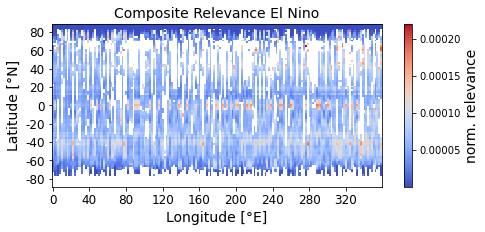

In [78]:
# Omit dummy column, which only served for capturing residual relevance:
R_all_mean_nino = R_all_mean_nino[:,1:]

# Set former NaN values to NaN, to highlight land masses:
R_all_mean_nino[R_all_mean_nino==0] = float("nan")

# baseESN, feed inputs col-wise into model, tanh activation, alpha = 0.01, 
# Mean relevance heatmap El Nino, CAPPED inputs (cap_limits = [-5, 5]), scaled to [-1,1]
# Single continuous normalized sst anomaly index as target.

## Plot mean relevance map over ALL El Nino samples, with bounding box arround Nino3.4 area
fig, ax = plt.subplots(figsize=(8, 3))

im = plt.imshow(R_all_mean_nino, cmap="coolwarm", interpolation='nearest', vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label("norm. relevance", fontsize=14)

plt.title('Composite Relevance El Nino', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 180, step=20), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([4, 14, 24, 34, 44, 54, 64, 74, 84], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

# Create a Rectangle patch and add the patch to the Axes
#rect = patches.Rectangle((95, 41), 25, 6, linewidth=2, edgecolor='black', facecolor='none')
#ax.add_patch(rect)

plt.show()

In [79]:
## Now reverse permutation to restore relevance map in its un-permuted form:

# Initialize storage (timesteps, features):
R_all_mean_nino_rev = np.zeros(R_all_mean_nino.shape)

# Get reverse permutation from argsort:
perm_rev = np.argsort(rand_perm)
  
# Loop over number of features:
for feat in range(R_all_mean_nino.shape[0]):

    # Store permutation:
    R_all_mean_nino_rev[feat,:] = R_all_mean_nino[feat, perm_rev]

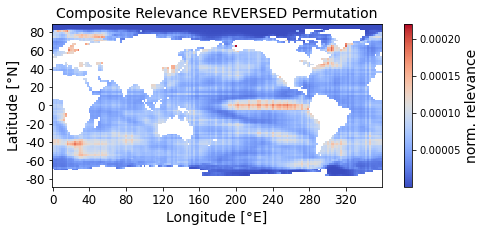

In [80]:
# baseESN, feed inputs col-wise into model, tanh activation, alpha = 0.01, 
# Mean relevance heatmap El Nino, CAPPED inputs (cap_limits = [-5, 5]), scaled to [-1,1]
# Single continuous normalized sst anomaly index as target.

## Plot mean relevance map over ALL El Nino samples, with bounding box arround Nino3.4 area
fig, ax = plt.subplots(figsize=(8, 3))

im = plt.imshow(R_all_mean_nino_rev, cmap="coolwarm", interpolation='nearest', vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label("norm. relevance", fontsize=14)

plt.title('Composite Relevance REVERSED Permutation', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 180, step=20), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([4, 14, 24, 34, 44, 54, 64, 74, 84], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

# Create a Rectangle patch and add the patch to the Axes
#rect = patches.Rectangle((95, 41), 25, 6, linewidth=2, edgecolor='black', facecolor='none')
#ax.add_patch(rect)

plt.show()